Team:  
Ling-I Huang (lih238@nyu.edu)  
Yu-Ting Chien (ytc354@nyu.edu)  
Prudhvi Ghanta (prudhvi.ghanta@stern.nyu.edu)  
Pradnya Wakchaure (pw1178@stern.nyu.edu)  

To open notebook in Colab please click below:
<a href="https://colab.research.google.com/github/bwolfson2/foster_2020/blob/master/Module2_Supervised/FP's_Supervised_segmentation.ipynb" target="_parent"> <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab" /> </a>'


In [135]:
#If opening in colab run this cell
!rm -rf DSBA_team1
!git clone https://github.com/liondon/DSBA_team1
%cd DSBA_team1

Cloning into 'DSBA_team1'...
remote: Enumerating objects: 43, done.
remote: Total 43 (delta 0), reused 0 (delta 0), pack-reused 43
Unpacking objects: 100% (43/43), done.
Checking out files: 100% (26/26), done.
/content/DSBA_team1/DSBA_team1/DSBA_team1/DSBA_team1


In [136]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.pylab as plt
import seaborn as sns

%matplotlib inline
sns.set(style='ticks', palette='Set2')

### Preprocess **Airline** datasets

#### 1. Extract previous years' `PASSENGERS` as features 

In [137]:
# Load datasets
years = [str(i).zfill(2) for i in range(0, 21)]
print("years=", end='')
print(years)

dfs = {}
for year in years:
  path = "./airline_data/T_T100_MARKET_ALL_CARRIER_20" + year + ".csv"
  dfs[year] = pd.read_csv(path)

  # Drop the empty column
  dfs[year].drop(columns=['Unnamed: 29'], inplace=True)

print("Does the columns of '20 and '19 match?")
print(dfs['20'].columns == dfs['19'].columns)
print("Does the columns of '20 and '00 match?")
print(dfs['20'].columns == dfs['00'].columns)

print(dfs['20'].shape)
dfs['20'].head(5)

years=['00', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20']
Does the columns of '20 and '19 match?
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
Does the columns of '20 and '00 match?
[ True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True]
(122328, 29)


,PASSENGERS,DISTANCE,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,REGION,ORIGIN_AIRPORT_ID,ORIGIN,ORIGIN_CITY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,ORIGIN_WAC,DEST_AIRPORT_ID,DEST,DEST_CITY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_COUNTRY,DEST_COUNTRY_NAME,DEST_WAC,YEAR,QUARTER,MONTH,DISTANCE_GROUP,CLASS,DATA_SOURCE
0,0.0,3855.0,3S,AeroLogic GmbH,I,12478,JFK,"New York, NY",NY,36.0,New York,US,United States,22,11760,FRA,"Frankfurt, Germany",NaN,NaN,NaN,DE,Germany,429,2020,1,1,8,G,IF
1,0.0,5805.0,3S,AeroLogic GmbH,I,12892,LAX,"Los Angeles, CA",CA,6.0,California,US,United States,91,11760,FRA,"Frankfurt, Germany",NaN,NaN,NaN,DE,Germany,429,2020,1,1,12,G,IF
2,0.0,4343.0,3S,AeroLogic GmbH,I,13930,ORD,"Chicago, IL",IL,17.0,Illinois,US,United States,41,11760,FRA,"Frankfurt, Germany",NaN,NaN,NaN,DE,Germany,429,2020,1,1,9,G,IF
3,0.0,935.0,3S,AeroLogic GmbH,I,13252,MEX,"Mexico City, Mexico",NaN,NaN,NaN,MX,Mexico,148,11298,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,US,United States,74,2020,1,1,2,G,IF
4,0.0,5142.0,3S,AeroLogic GmbH,I,11298,DFW,"Dallas/Fort Worth, TX",TX,48.0,Texas,US,United States,74,11760,FRA,"Frankfurt, Germany",NaN,NaN,NaN,DE,Germany,429,2020,1,1,11,G,IF


##### Add a key_col for each table 
NOTE: we're assuming the unique combination of the `keys` represents the total flights of a certain route for a carrier in a month 


In [138]:
# TODO: is there better way to do this? might wanna make it an index instead of a column

keys = ['UNIQUE_CARRIER', 'ORIGIN_AIRPORT_ID', 'DEST_AIRPORT_ID', 'MONTH'] 

for year in years:
  dfs[year]['key'] = dfs[year][keys].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

keys.append('key')
dfs['20'][keys].head(5)

,UNIQUE_CARRIER,ORIGIN_AIRPORT_ID,DEST_AIRPORT_ID,MONTH,key
0,3S,12478,11760,1,3S_12478_11760_1
1,3S,12892,11760,1,3S_12892_11760_1
2,3S,13930,11760,1,3S_13930_11760_1
3,3S,13252,11298,1,3S_13252_11298_1
4,3S,11298,11760,1,3S_11298_11760_1


##### Group records by `key` for each table
sum `PASSENGERS` for the same key  
Reference: https://www.shanelynn.ie/summarising-aggregation-and-grouping-data-in-python-pandas/


In [139]:
# NOTE: we're ignoring the difference from REGION, CLASS, DISTANCE(some noises at this col)
cols = dfs['20'].columns.difference(['PASSENGERS', 'REGION', 'CLASS', 'DISTANCE'])

aggregations = {
    'PASSENGERS':'sum',
}

In [140]:
# # Checking if there's multiple unique values in other columns... there shouldn't be any.
# for col in cols:
#     aggregations[col] = 'nunique'

# failed_grouped_df = {}
# for year in years:
#     grouped_df_check = dfs[year].groupby(['key']).agg(aggregations)
#     for col in cols:
#       if not grouped_df_check[grouped_df_check[col] > 1].empty:
#         print(col + " has multiple unique values for year " +year + "!")
#         failed_grouped_df[year] = grouped_df_check

In [141]:
# # Checking the col that has multi-value...
# failed_grouped_df['02'][failed_grouped_df['02']['DISTANCE'] > 1]
# dfs['02'][dfs['02']['key'] == 'H6_13970_14102_1']

In [142]:
# If there's no unexpected multi-unique-values, we can aggregate the rows for each group
grouped_dfs = {}
for col in cols:
    aggregations[col] = 'first' 
    # just use the first value we encountered, 
    # there should only be one unique value for these cols for each group as we checked
for year in years:
    grouped_dfs[year] = dfs[year].groupby(['key']).agg(aggregations)

grouped_dfs['20'].head(5)

,PASSENGERS,DATA_SOURCE,DEST,DEST_AIRPORT_ID,DEST_CITY_NAME,DEST_COUNTRY,DEST_COUNTRY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,DISTANCE_GROUP,MONTH,ORIGIN,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,QUARTER,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,YEAR,key
key,,,,,,,,,,,,,,,,,,,,,,,,,,,
02Q_11730_13303_2,52.0,IF,MIA,13303,"Miami, FL",US,United States,FL,12.0,Florida,33,7,2,FOR,11730,"Fortaleza, Brazil",BR,Brazil,None,NaN,None,316,1,02Q,Titan Airways,2020,02Q_11730_13303_2
02Q_11966_12264_5,31.0,IF,IAD,12264,"Washington, DC",US,United States,VA,51.0,Virginia,38,9,5,GOT,11966,"Gothenburg, Sweden",SE,Sweden,None,NaN,None,484,2,02Q,Titan Airways,2020,02Q_11966_12264_5
02Q_12266_12972_6,107.0,IF,LHR,12972,"London, United Kingdom",GB,United Kingdom,None,NaN,None,493,10,6,IAH,12266,"Houston, TX",US,United States,TX,48.0,Texas,74,2,02Q,Titan Airways,2020,02Q_12266_12972_6
02Q_12892_16050_6,23.0,IF,YFB,16050,"Iqaluit, Canada",CA,Canada,NU,NaN,Nunavut Territory,934,6,6,LAX,12892,"Los Angeles, CA",US,United States,CA,6.0,California,91,2,02Q,Titan Airways,2020,02Q_12892_16050_6
02Q_13204_16085_6,16.0,IF,YHZ,16085,"Halifax, Canada",CA,Canada,NS,NaN,Nova Scotia,951,3,6,MCO,13204,"Orlando, FL",US,United States,FL,12.0,Florida,33,2,02Q,Titan Airways,2020,02Q_13204_16085_6


In [143]:
# Take a look at the difference after grouping
print(dfs['20'].shape)
print(grouped_dfs['20'].shape)

(122328, 30)
(118987, 27)


##### Join tables
merge `PASSENGERS` from each year to 2020's table based on `key` 

In [144]:
# Join the tables based on `key` as indices

for year in years:
  if (year != '20'):
    # print(year)
    # print(grouped_dfs[year]["key"].value_counts()[:5])
    grouped_dfs['20'] = pd.merge(grouped_dfs['20'], grouped_dfs[year][['PASSENGERS']], 
                                 left_index=True, right_index=True, 
                                 validate="1:1", suffixes=('', '_' + year))
    
print(grouped_dfs['20'].shape)
grouped_dfs['20'].tail(5)

(11736, 47)


,PASSENGERS,DATA_SOURCE,DEST,DEST_AIRPORT_ID,DEST_CITY_NAME,DEST_COUNTRY,DEST_COUNTRY_NAME,DEST_STATE_ABR,DEST_STATE_FIPS,DEST_STATE_NM,DEST_WAC,DISTANCE_GROUP,MONTH,ORIGIN,ORIGIN_AIRPORT_ID,ORIGIN_CITY_NAME,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,ORIGIN_STATE_ABR,ORIGIN_STATE_FIPS,ORIGIN_STATE_NM,ORIGIN_WAC,QUARTER,UNIQUE_CARRIER,UNIQUE_CARRIER_NAME,YEAR,key,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WN_15376_14679_4,141.0,DU,SAN,14679,"San Diego, CA",US,United States,CA,6.0,California,91,1,4,TUS,15376,"Tucson, AZ",US,United States,AZ,4.0,Arizona,81,2,WN,Southwest Airlines Co.,2020,WN_15376_14679_4,8572.0,9016.0,7806.0,8467.0,8696.0,8525.0,8517.0,8238.0,9486.0,8519.0,8418.0,7114.0,7307.0,6184.0,7658.0,6876.0,6573.0,7011.0,6503.0,6035.0
WN_15376_14831_1,2980.0,DU,SJC,14831,"San Jose, CA",US,United States,CA,6.0,California,91,2,1,TUS,15376,"Tucson, AZ",US,United States,AZ,4.0,Arizona,81,1,WN,Southwest Airlines Co.,2020,WN_15376_14831_1,774.0,780.0,652.0,428.0,297.0,385.0,502.0,1170.0,938.0,746.0,628.0,962.0,295.0,389.0,313.0,113.0,123.0,190.0,410.0,2504.0
WN_15376_14831_3,1758.0,DU,SJC,14831,"San Jose, CA",US,United States,CA,6.0,California,91,2,3,TUS,15376,"Tucson, AZ",US,United States,AZ,4.0,Arizona,81,1,WN,Southwest Airlines Co.,2020,WN_15376_14831_3,874.0,570.0,500.0,479.0,375.0,462.0,1540.0,869.0,730.0,1077.0,99.0,1162.0,735.0,806.0,425.0,446.0,47.0,94.0,177.0,3006.0
WN_15376_14831_6,275.0,DU,SJC,14831,"San Jose, CA",US,United States,CA,6.0,California,91,2,6,TUS,15376,"Tucson, AZ",US,United States,AZ,4.0,Arizona,81,2,WN,Southwest Airlines Co.,2020,WN_15376_14831_6,817.0,452.0,417.0,274.0,819.0,393.0,1586.0,942.0,680.0,1526.0,434.0,1250.0,697.0,604.0,351.0,86.0,311.0,82.0,30.0,2645.0
WN_15376_14893_1,70.0,DU,SMF,14893,"Sacramento, CA",US,United States,CA,6.0,California,91,2,1,TUS,15376,"Tucson, AZ",US,United States,AZ,4.0,Arizona,81,1,WN,Southwest Airlines Co.,2020,WN_15376_14893_1,429.0,487.0,294.0,327.0,179.0,771.0,874.0,266.0,317.0,389.0,315.0,694.0,488.0,99.0,56.0,56.0,47.0,321.0,445.0,26.0


In [145]:
# # Checking if the merge is correct...
# print(grouped_dfs['20'].loc['WN_15376_14831_1']['PASSENGERS'])
# print(grouped_dfs['00'].loc['WN_15376_14831_1']['PASSENGERS'])

#### 2. Split up the data into **US Domestic** and **International**

In [146]:
df = grouped_dfs['20']

In [147]:
# Check if there is any row with DATA_SOURCE=NaN
print('#(DATA_SOURCE == NaN): ' + str(df['DATA_SOURCE'].isna().sum()))
# df.dropna(subset=['DATA_SOURCE'], inplace=True)
# print('#(DATA_SOURCE == NaN): ' + str(df['DATA_SOURCE'].isna().sum()))

# Split df to two dataframe (DATA_SOURCE: 'D' for domestic, 'I' for intl)
dom_df = df[df['DATA_SOURCE'].str.contains('D.*', na=False, regex=True)]
intl_airline_df = df[df['DATA_SOURCE'].str.contains('I.*', na=False, regex=True)]

# check if the split is correct
print('dom_df.size: ' + str(dom_df.size))
print('intl_airline_df.size: ' + str(intl_airline_df.size))
print('dom_df.size + intl_airline_df.size = ' + str(dom_df.size + intl_airline_df.size))
print('df.size: ' + str(df.size))

#(DATA_SOURCE == NaN): 0
dom_df.size: 410968
intl_airline_df.size: 140624
dom_df.size + intl_airline_df.size = 551592
df.size: 551592


In [148]:
# Drop useless columns in dom_df
dom_df.drop(columns=['UNIQUE_CARRIER_NAME', 
                     'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_WAC',
                     'ORIGIN_CITY_NAME', 'ORIGIN_STATE_FIPS', 
                     'ORIGIN_COUNTRY', 'ORIGIN_COUNTRY_NAME', 
                     'DEST_AIRPORT_ID', 'DEST', 'DEST_WAC',
                     'DEST_CITY_NAME', 'DEST_STATE_FIPS', 
                     'DEST_COUNTRY', 'DEST_COUNTRY_NAME'], 
            inplace=True)

# Drop rows with 0 passengers
dom_df = dom_df[dom_df['PASSENGERS'] > 0]

# Take a look at the data
print(dom_df.describe())
dom_df.head(5)

         PASSENGERS  DISTANCE_GROUP  ...  PASSENGERS_18  PASSENGERS_19
count   8658.000000     8658.000000  ...    8658.000000    8658.000000
mean    7669.204666        2.329522  ...   15873.796142   16262.503350
std    10047.768271        1.296109  ...   14143.306209   14422.838374
min        1.000000        1.000000  ...       0.000000       0.000000
25%     1117.000000        1.000000  ...    5874.500000    6028.500000
50%     4036.000000        2.000000  ...   11586.000000   11769.500000
75%    10128.750000        3.000000  ...   22167.000000   22741.750000
max    91173.000000       10.000000  ...   93737.000000   97383.000000

[8 rows x 25 columns]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,PASSENGERS,DATA_SOURCE,DEST_STATE_ABR,DEST_STATE_NM,DISTANCE_GROUP,MONTH,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,QUARTER,UNIQUE_CARRIER,YEAR,key,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5V_11463_11630_1,45.0,DU,AK,Alaska,1,1,AK,Alaska,1,5V,2020,5V_11463_11630_1,2.0,0.0,3.0,57.0,41.0,38.0,55.0,63.0,53.0,51.0,48.0,31.0,49.0,37.0,45.0,42.0,32.0,40.0,59.0,57.0
5V_11463_11630_2,69.0,DU,AK,Alaska,1,2,AK,Alaska,1,5V,2020,5V_11463_11630_2,0.0,0.0,8.0,55.0,62.0,59.0,45.0,41.0,40.0,64.0,56.0,40.0,49.0,50.0,39.0,52.0,71.0,51.0,65.0,80.0
5V_11463_11630_3,52.0,DU,AK,Alaska,1,3,AK,Alaska,1,5V,2020,5V_11463_11630_3,0.0,1.0,1.0,58.0,64.0,76.0,66.0,71.0,72.0,63.0,70.0,67.0,64.0,59.0,46.0,50.0,83.0,69.0,71.0,64.0
5V_11463_11630_6,25.0,DU,AK,Alaska,1,6,AK,Alaska,2,5V,2020,5V_11463_11630_6,6.0,2.0,7.0,52.0,36.0,45.0,57.0,43.0,46.0,32.0,60.0,43.0,54.0,37.0,53.0,27.0,18.0,32.0,33.0,42.0
5V_11630_11463_1,62.0,DU,AK,Alaska,1,1,AK,Alaska,1,5V,2020,5V_11630_11463_1,2.0,0.0,2.0,59.0,46.0,38.0,49.0,48.0,43.0,35.0,46.0,38.0,42.0,38.0,44.0,51.0,44.0,48.0,57.0,57.0


In [149]:
# Drop useless columns in itnl_df
intl_airline_df.drop(columns=['UNIQUE_CARRIER_NAME', 
                      'ORIGIN_AIRPORT_ID', 'ORIGIN', 'ORIGIN_WAC', 
                      'ORIGIN_CITY_NAME', 'ORIGIN_STATE_FIPS', 
                      'ORIGIN_STATE_ABR', 'ORIGIN_STATE_NM',
                      'DEST_AIRPORT_ID', 'DEST', 'DEST_WAC', 
                      'DEST_CITY_NAME', 'DEST_STATE_FIPS', 
                      'DEST_STATE_ABR', 'DEST_STATE_NM'],
             inplace=True)

# Take a look at the data
print(intl_airline_df.describe())
intl_airline_df.head(5)

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


         PASSENGERS  DISTANCE_GROUP  ...  PASSENGERS_18  PASSENGERS_19
count   2992.000000     2992.000000  ...    2992.000000    2992.000000
mean    4160.961230        8.075535  ...    8208.809492    8423.694184
std     5091.337696        4.343144  ...    7653.110957    7929.162442
min        0.000000        1.000000  ...       0.000000       0.000000
25%      144.000000        4.000000  ...    3233.750000    3291.750000
50%     2535.500000        8.000000  ...    6395.500000    6489.500000
75%     6208.250000       11.000000  ...   11416.500000   11618.750000
max    34761.000000       21.000000  ...   61577.000000   58959.000000

[8 rows x 25 columns]


,PASSENGERS,DATA_SOURCE,DEST_COUNTRY,DEST_COUNTRY_NAME,DISTANCE_GROUP,MONTH,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,QUARTER,UNIQUE_CARRIER,YEAR,key,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5X_10299_12143_1,0.0,IU,HK,Hong Kong,11,1,US,United States,1,5X,2020,5X_10299_12143_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5X_10299_12143_4,0.0,IU,HK,Hong Kong,11,4,US,United States,2,5X,2020,5X_10299_12143_4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5X_10299_12143_5,0.0,IU,HK,Hong Kong,11,5,US,United States,2,5X,2020,5X_10299_12143_5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5X_10299_12143_6,0.0,IU,HK,Hong Kong,11,6,US,United States,2,5X,2020,5X_10299_12143_6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5X_10299_12699_1,0.0,IU,JP,Japan,8,1,US,United States,1,5X,2020,5X_10299_12699_1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Preprocess **US Domestic** COVID datasets 

In [150]:
def extract_features_covid(df, tag):

  cummulative = 0

  # aggregate case number in same month
  for i in range(0, 12):
    month = str(i+1)
    year = '20'
    regex = '^' + month + '/..?/..'

    monthly = df.filter(regex=regex, axis=1)
    # print(monthly)

    # total in the month
    df[month + '_monthlySum_' + tag] = monthly.sum(axis=1)

    # daily avg for the month
    df[month + '_dailyAvg_' + tag] = monthly.sum(axis=1) / monthly.columns.size

    # cummulative sum for the month
    cummulative += df[month + '_monthlySum_' + tag]
    df[month + '_cummulativeSum_' + tag] = cummulative

    # total in k-th week of the month
    # TODO: ignoring 30th and 31st for now... what's the best way to include them? using avg?
    for k in range(0, 4):
      sum = 0
      week = str(k+1)
      for i in range(1, 8):
        date = month + '/' + str(7*k+i) + '/' + year
        # print(date)
        if date in monthly.columns:
          sum += monthly[date]

      df[month + '_' + week + 'thWeekSum_' + tag] = sum
      # print(df[month + '_' + week + 'thWeek' + tag])
      # print('###################################################')  

    # drop the original daily columns
    df.drop(columns=monthly.columns, inplace=True)
    # print(df.head(5))

  return df

In [151]:
# Read COVID US data directly from John Hopkins' repo
path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv'
confirmed_df = pd.read_csv(path)

# drop useless columns
confirmed_df.drop(columns=['UID','iso2','iso3', 'code3','FIPS','Admin2', 
                           'Country_Region', 'Lat', 'Long_', 'Combined_Key'], 
                  inplace=True)

confirmed_df = extract_features_covid(confirmed_df, 'confirmed')

# aggregate case number in same state
confirmed_df = confirmed_df.groupby(by='Province_State').sum()

print(confirmed_df.shape)
confirmed_df.head(5)

(58, 84)


,1_monthlySum_confirmed,1_dailyAvg_confirmed,1_cummulativeSum_confirmed,1_1thWeekSum_confirmed,1_2thWeekSum_confirmed,1_3thWeekSum_confirmed,1_4thWeekSum_confirmed,2_monthlySum_confirmed,2_dailyAvg_confirmed,2_cummulativeSum_confirmed,2_1thWeekSum_confirmed,2_2thWeekSum_confirmed,2_3thWeekSum_confirmed,2_4thWeekSum_confirmed,3_monthlySum_confirmed,3_dailyAvg_confirmed,3_cummulativeSum_confirmed,3_1thWeekSum_confirmed,3_2thWeekSum_confirmed,3_3thWeekSum_confirmed,3_4thWeekSum_confirmed,4_monthlySum_confirmed,4_dailyAvg_confirmed,4_cummulativeSum_confirmed,4_1thWeekSum_confirmed,4_2thWeekSum_confirmed,4_3thWeekSum_confirmed,4_4thWeekSum_confirmed,5_monthlySum_confirmed,5_dailyAvg_confirmed,5_cummulativeSum_confirmed,5_1thWeekSum_confirmed,5_2thWeekSum_confirmed,5_3thWeekSum_confirmed,5_4thWeekSum_confirmed,6_monthlySum_confirmed,6_dailyAvg_confirmed,6_cummulativeSum_confirmed,6_1thWeekSum_confirmed,6_2thWeekSum_confirmed,...,7_cummulativeSum_confirmed,7_1thWeekSum_confirmed,7_2thWeekSum_confirmed,7_3thWeekSum_confirmed,7_4thWeekSum_confirmed,8_monthlySum_confirmed,8_dailyAvg_confirmed,8_cummulativeSum_confirmed,8_1thWeekSum_confirmed,8_2thWeekSum_confirmed,8_3thWeekSum_confirmed,8_4thWeekSum_confirmed,9_monthlySum_confirmed,9_dailyAvg_confirmed,9_cummulativeSum_confirmed,9_1thWeekSum_confirmed,9_2thWeekSum_confirmed,9_3thWeekSum_confirmed,9_4thWeekSum_confirmed,10_monthlySum_confirmed,10_dailyAvg_confirmed,10_cummulativeSum_confirmed,10_1thWeekSum_confirmed,10_2thWeekSum_confirmed,10_3thWeekSum_confirmed,10_4thWeekSum_confirmed,11_monthlySum_confirmed,11_dailyAvg_confirmed,11_cummulativeSum_confirmed,11_1thWeekSum_confirmed,11_2thWeekSum_confirmed,11_3thWeekSum_confirmed,11_4thWeekSum_confirmed,12_monthlySum_confirmed,12_dailyAvg_confirmed,12_cummulativeSum_confirmed,12_1thWeekSum_confirmed,12_2thWeekSum_confirmed,12_3thWeekSum_confirmed,12_4thWeekSum_confirmed
Province_State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,6735,217.258065,6735,0,30,528,3233,127476,4249.200000,134211,12171,23604,33662,43873,377501,12177.451613,511712,57724,71950,87498,107178,812738,27091.266667,1324450,136517,165082,...,3263388,301760,371208,460224,546164,3358162,108327.806452,6621550,658978,722487,772745,828353,4214797,140493.233333,10836347,909897,951957,997410,1047177,5351525,172629.838710,16187872,1111073,1159222,1212034,1293538,6594967,219832.233333,22782839,1392758,1466484,1566379,1672593,3267371,272280.916667,26050210,1843981,1423390,0,0
Alaska,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,808,26.064516,808,0,2,58,389,8403,280.100000,9211,1220,1822,2219,2422,12586,406.000000,21797,2620,2719,2863,2995,23313,777.100000,45110,3846,4737,...,113478,9287,11835,15574,20868,156848,5059.612903,270326,28953,32620,36652,40229,222916,7430.533333,493242,45318,49102,53075,57837,370781,11960.677419,864023,66057,74548,84282,98109,725014,24167.133333,1589037,125249,149659,178691,206774,444291,37024.250000,2033328,247651,196640,0,0
American Samoa,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,...,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0
Arizona,6,0.6,6,0,0,0,3,29,1.0,35,7,7,7,7,6783,218.806452,6818,11,53,294,3060,128753,4291.766667,135571,14101,23305,32693,43790,417640,13472.258065,553211,62854,80614,99818,116688,1294975,43165.833333,1848186,163514,220498,...,5951318,662641,832495,983245,1111670,5950207,191942.161290,11901525,1266383,1321248,1363852,1393941,6319715,210657.166667,18221240,1431085,1452476,1485541,1513922,7141160,230360.000000,25362400,1545670,1578457,1618588,1665974,8435286,281176.200000,33797686,1760979,1856451,1989601,2175443,4411047,367587.250000,38208733,2465659,1945388,0,0
Arkansas,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,3721,120.032258,3721,0,21,297,1981,52677,1755.900000,56398,5332,8706,12372,19793,150164,4844.000000,206562,24476,28315,33997,42333,4

In [152]:
# do the same for death data
path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_US.csv'
death_df = pd.read_csv(path)

death_df.drop(columns=['UID','iso2','iso3', 'code3','FIPS','Admin2', 
                       'Country_Region', 'Lat', 'Long_', 'Combined_Key', 
                       'Population'], 
              inplace=True)

death_df = extract_features_covid(death_df, 'death')
death_df = death_df.groupby(by='Province_State').sum()

print(death_df.shape)
death_df.head(5)

(58, 84)


,1_monthlySum_death,1_dailyAvg_death,1_cummulativeSum_death,1_1thWeekSum_death,1_2thWeekSum_death,1_3thWeekSum_death,1_4thWeekSum_death,2_monthlySum_death,2_dailyAvg_death,2_cummulativeSum_death,2_1thWeekSum_death,2_2thWeekSum_death,2_3thWeekSum_death,2_4thWeekSum_death,3_monthlySum_death,3_dailyAvg_death,3_cummulativeSum_death,3_1thWeekSum_death,3_2thWeekSum_death,3_3thWeekSum_death,3_4thWeekSum_death,4_monthlySum_death,4_dailyAvg_death,4_cummulativeSum_death,4_1thWeekSum_death,4_2thWeekSum_death,4_3thWeekSum_death,4_4thWeekSum_death,5_monthlySum_death,5_dailyAvg_death,5_cummulativeSum_death,5_1thWeekSum_death,5_2thWeekSum_death,5_3thWeekSum_death,5_4thWeekSum_death,6_monthlySum_death,6_dailyAvg_death,6_cummulativeSum_death,6_1thWeekSum_death,6_2thWeekSum_death,...,7_cummulativeSum_death,7_1thWeekSum_death,7_2thWeekSum_death,7_3thWeekSum_death,7_4thWeekSum_death,8_monthlySum_death,8_dailyAvg_death,8_cummulativeSum_death,8_1thWeekSum_death,8_2thWeekSum_death,8_3thWeekSum_death,8_4thWeekSum_death,9_monthlySum_death,9_dailyAvg_death,9_cummulativeSum_death,9_1thWeekSum_death,9_2thWeekSum_death,9_3thWeekSum_death,9_4thWeekSum_death,10_monthlySum_death,10_dailyAvg_death,10_cummulativeSum_death,10_1thWeekSum_death,10_2thWeekSum_death,10_3thWeekSum_death,10_4thWeekSum_death,11_monthlySum_death,11_dailyAvg_death,11_cummulativeSum_death,11_1thWeekSum_death,11_2thWeekSum_death,11_3thWeekSum_death,11_4thWeekSum_death,12_monthlySum_death,12_dailyAvg_death,12_cummulativeSum_death,12_1thWeekSum_death,12_2thWeekSum_death,12_3thWeekSum_death,12_4thWeekSum_death
Province_State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,53,1.709677,53,0,0,0,10,4001,133.366667,4054,299,614,1055,1505,14438,465.741935,18492,2192,2927,3500,3961,23697,789.9,42189,4662,5261,...,80625,7017,7753,8873,10110,58883,1899.451613,139508,11673,12832,13569,14313,71418,2380.600000,210926,15743,16252,16921,17445,85064,2744.000000,295990,17954,18654,19540,20103,98538,3284.600000,394528,21096,22179,23472,24636,46763,3896.916667,441291,26614,20149,0,0
Alaska,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,13,0.419355,13,0,0,0,5,230,7.666667,243,32,54,63,63,305,9.838710,548,65,70,70,70,351,11.7,899,70,79,...,1457,108,119,123,140,912,29.419355,2369,173,185,201,242,1361,45.366667,3730,284,301,312,352,2017,65.064516,5747,405,424,467,481,2973,99.100000,8720,587,647,700,797,1733,144.416667,10453,948,785,0,0
American Samoa,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.0,0,0,0,...,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0
Arizona,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,114,3.677419,114,0,0,1,51,4912,163.733333,5026,365,810,1265,1844,19861,640.677419,24887,2655,3908,4913,5688,37494,1249.8,62381,6952,7901,...,142079,12685,15054,18702,22483,137942,4449.741935,280021,27151,29793,32039,33893,161366,5378.866667,441387,36057,36992,37997,39038,179972,5805.548387,621359,39931,40305,40767,41138,189497,6316.566667,810856,42383,43545,44549,45747,83732,6977.666667,894588,47957,35775,0,0
Arkansas,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,35,1.129032,35,0,0,0,14,997,33.233333,1032,98,173,267,341,3136,101.161290,4168,549,651,713,825,5895,196.5,10063,1022,1184,...,20892,2003,2221,2480,2796,19076,615.354839,39968,3431,3941,4356,4995,32549,1084.966667,72517,6073,6680,8205,8872,51328,1655.741935,123845,10005,10985,11891,12728,66765,2225.500000,190610,14133,14882,15883,16895,32312,2692.666667,222922,18168,14144,0,0


In [153]:
# join confirmed_df and death_df
dom_covid_df = confirmed_df.join(death_df)

print(dom_covid_df.shape)
dom_covid_df

(58, 168)


,1_monthlySum_confirmed,1_dailyAvg_confirmed,1_cummulativeSum_confirmed,1_1thWeekSum_confirmed,1_2thWeekSum_confirmed,1_3thWeekSum_confirmed,1_4thWeekSum_confirmed,2_monthlySum_confirmed,2_dailyAvg_confirmed,2_cummulativeSum_confirmed,2_1thWeekSum_confirmed,2_2thWeekSum_confirmed,2_3thWeekSum_confirmed,2_4thWeekSum_confirmed,3_monthlySum_confirmed,3_dailyAvg_confirmed,3_cummulativeSum_confirmed,3_1thWeekSum_confirmed,3_2thWeekSum_confirmed,3_3thWeekSum_confirmed,3_4thWeekSum_confirmed,4_monthlySum_confirmed,4_dailyAvg_confirmed,4_cummulativeSum_confirmed,4_1thWeekSum_confirmed,4_2thWeekSum_confirmed,4_3thWeekSum_confirmed,4_4thWeekSum_confirmed,5_monthlySum_confirmed,5_dailyAvg_confirmed,5_cummulativeSum_confirmed,5_1thWeekSum_confirmed,5_2thWeekSum_confirmed,5_3thWeekSum_confirmed,5_4thWeekSum_confirmed,6_monthlySum_confirmed,6_dailyAvg_confirmed,6_cummulativeSum_confirmed,6_1thWeekSum_confirmed,6_2thWeekSum_confirmed,...,7_cummulativeSum_death,7_1thWeekSum_death,7_2thWeekSum_death,7_3thWeekSum_death,7_4thWeekSum_death,8_monthlySum_death,8_dailyAvg_death,8_cummulativeSum_death,8_1thWeekSum_death,8_2thWeekSum_death,8_3thWeekSum_death,8_4thWeekSum_death,9_monthlySum_death,9_dailyAvg_death,9_cummulativeSum_death,9_1thWeekSum_death,9_2thWeekSum_death,9_3thWeekSum_death,9_4thWeekSum_death,10_monthlySum_death,10_dailyAvg_death,10_cummulativeSum_death,10_1thWeekSum_death,10_2thWeekSum_death,10_3thWeekSum_death,10_4thWeekSum_death,11_monthlySum_death,11_dailyAvg_death,11_cummulativeSum_death,11_1thWeekSum_death,11_2thWeekSum_death,11_3thWeekSum_death,11_4thWeekSum_death,12_monthlySum_death,12_dailyAvg_death,12_cummulativeSum_death,12_1thWeekSum_death,12_2thWeekSum_death,12_3thWeekSum_death,12_4thWeekSum_death
Province_State,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Alabama,0,0.0,0,0,0,0,0,0,0.000000,0,0,0,0,0,6735,217.258065,6735,0,30,528,3233,127476,4249.200000,134211,12171,23604,33662,43873,377501,12177.451613,511712,57724,71950,87498,107178,812738,27091.266667,1324450,136517,165082,...,80625,7017,7753,8873,10110,58883,1899.451613,139508,11673,12832,13569,14313,71418,2380.600000,210926,15743,16252,16921,17445,85064,2744.000000,295990,17954,18654,19540,20103,98538,3284.600000,394528,21096,22179,23472,24636,46763,3896.916667,441291,26614,20149,0,0
Alaska,0,0.0,0,0,0,0,0,0,0.000000,0,0,0,0,0,808,26.064516,808,0,2,58,389,8403,280.100000,9211,1220,1822,2219,2422,12586,406.000000,21797,2620,2719,2863,2995,23313,777.100000,45110,3846,4737,...,1457,108,119,123,140,912,29.419355,2369,173,185,201,242,1361,45.366667,3730,284,301,312,352,2017,65.064516,5747,405,424,467,481,2973,99.100000,8720,587,647,700,797,1733,144.416667,10453,948,785,0,0
American Samoa,0,0.0,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,...,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0,0,0.000000,0,0,0,0,0
Arizona,6,0.6,6,0,0,0,3,29,1.000000,35,7,7,7,7,6783,218.806452,6818,11,53,294,3060,128753,4291.766667,135571,14101,23305,32693,43790,417640,13472.258065,553211,62854,80614,99818,116688,1294975,43165.833333,1848186,163514,220498,...,142079,12685,15054,18702,22483,137942,4449.741935,280021,27151,29793,32039,33893,161366,5378.866667,441387,36057,36992,37997,39038,179972,5805.548387,621359,39931,40305,40767,41138,189497,6316.566667,810856,42383,43545,44549,45747,83732,6977.666667,894588,47957,35775,0,0
Arkansas,0,0.0,0,0,0,0,0,0,0.000000,0,0,0,0,0,3721,120.032258,3721,0,21,297,1981,52677,1755.900000,56398,5332,8706,12372,19793,150164,4844.000000,206562,24476,28315,33997,42333,402154,13405.133333,608716,58931,77147,...,20892,2003,2221,2480,2796,19076,615.354839,39968,3431,3941,4356,4995,32549,1084.966667,72517,6073,6680,8205,8872,51328,1655.741935,123845,10005,10985,11891,12728,66765,2225.500000,190610,14133,14882,15883,16895,32312,2692.666667,222922,18168,14144,0,0
California,13,1.3,13,0,0,0,6,226,7.793103,239,36,48,58,72,520

### Preprocess **International** COVID datasets

In [154]:
# Read COVID US data directly from John Hopkins' repo
path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
intl_confirmed_df = pd.read_csv(path)

# These regions are considered as 'Country/Region' at ariline data, so we do the same at COVID data here.
regions = {'Sint Maarten', 'Bermuda', 'Aruba', 'Turks and Caicos Islands', 
           'Hong Kong', 'Cayman Islands', 'French Polynesia', 
           'Cook Islands', 'Curacao', 'Guadeloupe'}
for region in regions:
  intl_confirmed_df.loc[intl_confirmed_df['Province/State'] == region, 'Country/Region'] = region
  # print(intl_confirmed_df[intl_confirmed_df['Province/State'] == region])

# drop useless columns
intl_confirmed_df.drop(columns=['Province/State', 'Lat', 'Long'], 
                  inplace=True)

intl_confirmed_df = extract_features_covid(intl_confirmed_df, 'confirmed')

# aggregate case number in same country
intl_confirmed_df = intl_confirmed_df.groupby(by='Country/Region').sum()

print(intl_confirmed_df.shape)
intl_confirmed_df.head(5)

(200, 84)


,1_monthlySum_confirmed,1_dailyAvg_confirmed,1_cummulativeSum_confirmed,1_1thWeekSum_confirmed,1_2thWeekSum_confirmed,1_3thWeekSum_confirmed,1_4thWeekSum_confirmed,2_monthlySum_confirmed,2_dailyAvg_confirmed,2_cummulativeSum_confirmed,2_1thWeekSum_confirmed,2_2thWeekSum_confirmed,2_3thWeekSum_confirmed,2_4thWeekSum_confirmed,3_monthlySum_confirmed,3_dailyAvg_confirmed,3_cummulativeSum_confirmed,3_1thWeekSum_confirmed,3_2thWeekSum_confirmed,3_3thWeekSum_confirmed,3_4thWeekSum_confirmed,4_monthlySum_confirmed,4_dailyAvg_confirmed,4_cummulativeSum_confirmed,4_1thWeekSum_confirmed,4_2thWeekSum_confirmed,4_3thWeekSum_confirmed,4_4thWeekSum_confirmed,5_monthlySum_confirmed,5_dailyAvg_confirmed,5_cummulativeSum_confirmed,5_1thWeekSum_confirmed,5_2thWeekSum_confirmed,5_3thWeekSum_confirmed,5_4thWeekSum_confirmed,6_monthlySum_confirmed,6_dailyAvg_confirmed,6_cummulativeSum_confirmed,6_1thWeekSum_confirmed,6_2thWeekSum_confirmed,...,7_cummulativeSum_confirmed,7_1thWeekSum_confirmed,7_2thWeekSum_confirmed,7_3thWeekSum_confirmed,7_4thWeekSum_confirmed,8_monthlySum_confirmed,8_dailyAvg_confirmed,8_cummulativeSum_confirmed,8_1thWeekSum_confirmed,8_2thWeekSum_confirmed,8_3thWeekSum_confirmed,8_4thWeekSum_confirmed,9_monthlySum_confirmed,9_dailyAvg_confirmed,9_cummulativeSum_confirmed,9_1thWeekSum_confirmed,9_2thWeekSum_confirmed,9_3thWeekSum_confirmed,9_4thWeekSum_confirmed,10_monthlySum_confirmed,10_dailyAvg_confirmed,10_cummulativeSum_confirmed,10_1thWeekSum_confirmed,10_2thWeekSum_confirmed,10_3thWeekSum_confirmed,10_4thWeekSum_confirmed,11_monthlySum_confirmed,11_dailyAvg_confirmed,11_cummulativeSum_confirmed,11_1thWeekSum_confirmed,11_2thWeekSum_confirmed,11_3thWeekSum_confirmed,11_4thWeekSum_confirmed,12_monthlySum_confirmed,12_dailyAvg_confirmed,12_cummulativeSum_confirmed,12_1thWeekSum_confirmed,12_2thWeekSum_confirmed,12_3thWeekSum_confirmed,12_4thWeekSum_confirmed
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0.0,0,0,0,0,0,6,0.206897,6,0,0,0,5,1164,37.548387,1170,20,71,162,472,27074,902.466667,28244,2142,4007,6584,10274,225674,7279.806452,253918,20543,32748,50672,78313,750944,25031.466667,1004862,126463,159848,...,2082109,228309,239788,247093,252397,1163297,37525.709677,3245406,257665,260797,263996,266392,1163868,38795.600000,4409274,268244,270371,272476,274255,1245948,40191.870968,5655222,275669,278603,281621,286028,1308111,43603.700000,6963333,292619,298327,307356,317419,568767,47397.250000,7532100,328802,239965,0,0
Albania,0,0.0,0,0,0,0,0,0,0.000000,0,0,0,0,0,2232,72.000000,2232,0,118,417,1019,15632,521.066667,17864,2294,3046,3854,4899,28873,931.387097,46737,5663,6100,6625,7127,50880,1696.000000,97617,8378,9689,...,217277,19708,23635,28068,32671,230278,7428.322581,447555,40341,46803,53691,61271,350148,11671.600000,797703,69908,77196,84655,91222,523084,16873.677419,1320787,99862,107872,119491,134035,866248,28874.933333,2187035,156565,180177,209503,244196,519645,43303.750000,2706680,289355,230290,0,0
Algeria,0,0.0,0,0,0,0,0,5,0.172414,5,0,0,0,4,4823,155.580645,4828,67,166,552,2227,69497,2316.566667,74325,8466,12791,17538,22848,211394,6819.161290,285719,32588,41303,50317,59391,337819,11260.633333,623538,68842,74147,...,1297824,108723,131210,157675,187224,1185076,38228.258065,2482900,227727,253319,275957,295652,1458290,48609.666667,3941190,320321,334151,345779,355141,1683631,54310.677419,5624821,364857,371782,380906,393161,2074384,69146.133333,7699205,417702,450349,494669,546244,1059240,88270.000000,8758445,606472,452768,0,0
Andorra,0,0.0,0,0,0,0,0,0,0.000000,0,0,0,0,0,2787,89.903226,2787,6,7,297,1397,19106,636.866667,21893,3294,4292,4893,5139,23498,758.000000,45391,5244,5295,5329,5338,25511,850.366667,70902,5868,5967,...,98076,5985,5994,6147,6283,31382,1012.322581,129458,6564,6783,7081,7530,45275,1509.166667,174733,8488,9333,10777,12661,103067,3324.741935,277800,15688,19836,24378,29177,174907,5830.233333,452707,35257,38930,42170,45093,84633,7052.750000,537340,48630,360

In [155]:
# Read COVID US data directly from John Hopkins' repo
path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
intl_death_df = pd.read_csv(path)

for region in regions:
  intl_death_df.loc[intl_death_df['Province/State'] == region, 'Country/Region'] = region
  # print(intl_death_df[intl_death_df['Province/State'] == region])

# drop useless columns
intl_death_df.drop(columns=['Province/State', 'Lat', 'Long'], 
                  inplace=True)

intl_death_df = extract_features_covid(intl_death_df, 'death')

# aggregate case number in same country
intl_death_df = intl_death_df.groupby(by='Country/Region').sum()

print(intl_death_df.shape)
intl_death_df.head(5)

(200, 84)


,1_monthlySum_death,1_dailyAvg_death,1_cummulativeSum_death,1_1thWeekSum_death,1_2thWeekSum_death,1_3thWeekSum_death,1_4thWeekSum_death,2_monthlySum_death,2_dailyAvg_death,2_cummulativeSum_death,2_1thWeekSum_death,2_2thWeekSum_death,2_3thWeekSum_death,2_4thWeekSum_death,3_monthlySum_death,3_dailyAvg_death,3_cummulativeSum_death,3_1thWeekSum_death,3_2thWeekSum_death,3_3thWeekSum_death,3_4thWeekSum_death,4_monthlySum_death,4_dailyAvg_death,4_cummulativeSum_death,4_1thWeekSum_death,4_2thWeekSum_death,4_3thWeekSum_death,4_4thWeekSum_death,5_monthlySum_death,5_dailyAvg_death,5_cummulativeSum_death,5_1thWeekSum_death,5_2thWeekSum_death,5_3thWeekSum_death,5_4thWeekSum_death,6_monthlySum_death,6_dailyAvg_death,6_cummulativeSum_death,6_1thWeekSum_death,6_2thWeekSum_death,...,7_cummulativeSum_death,7_1thWeekSum_death,7_2thWeekSum_death,7_3thWeekSum_death,7_4thWeekSum_death,8_monthlySum_death,8_dailyAvg_death,8_cummulativeSum_death,8_1thWeekSum_death,8_2thWeekSum_death,8_3thWeekSum_death,8_4thWeekSum_death,9_monthlySum_death,9_dailyAvg_death,9_cummulativeSum_death,9_1thWeekSum_death,9_2thWeekSum_death,9_3thWeekSum_death,9_4thWeekSum_death,10_monthlySum_death,10_dailyAvg_death,10_cummulativeSum_death,10_1thWeekSum_death,10_2thWeekSum_death,10_3thWeekSum_death,10_4thWeekSum_death,11_monthlySum_death,11_dailyAvg_death,11_cummulativeSum_death,11_1thWeekSum_death,11_2thWeekSum_death,11_3thWeekSum_death,11_4thWeekSum_death,12_monthlySum_death,12_dailyAvg_death,12_cummulativeSum_death,12_1thWeekSum_death,12_2thWeekSum_death,12_3thWeekSum_death,12_4thWeekSum_death
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,27,0.870968,27,0,0,0,15,890,29.666667,917,69,133,224,339,5007,161.516129,5924,620,861,1224,1547,15016,500.533333,20940,2147,2980,...,54458,5926,6983,8084,8685,42101,1358.096774,96559,9058,9402,9663,9769,42987,1432.900000,139546,9876,9951,10071,10169,46287,1493.129032,185833,10256,10346,10457,10621,49133,1637.766667,234966,10853,11106,11541,12064,22654,1887.833333,257620,12993,9661,0,0
Albania,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,91,2.935484,91,0,4,11,40,728,24.266667,819,131,161,181,194,975,31.451613,1794,217,217,217,225,1221,40.700000,3015,233,245,...,6317,516,625,765,935,6945,224.032258,13262,1234,1437,1627,1808,10286,342.866667,23548,2140,2296,2467,2612,13731,442.935484,37279,2775,2947,3155,3344,19239,641.300000,56518,3762,4114,4551,5204,10917,909.750000,67435,6099,4818,0,0
Algeria,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,324,10.451613,324,0,6,54,154,9197,306.566667,9521,897,1903,2566,2937,16901,545.193548,26422,3269,3557,3885,4253,23600,786.666667,50022,4777,5190,...,82742,6610,7023,7482,8009,42428,1368.645161,125170,8757,9254,9731,10184,48964,1632.133333,174134,10776,11179,11606,11941,57192,1844.903226,231326,12313,12622,12988,13400,65248,2174.933333,296574,14003,14654,15429,16321,30243,2520.250000,326817,17427,12816,0,0
Andorra,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,39,1.258065,39,0,0,0,13,917,30.566667,956,123,189,246,275,1518,48.967742,2474,316,337,355,357,1545,51.500000,4019,357,357,...,5631,364,364,364,364,1632,52.645161,7263,364,367,371,371,1590,53.000000,8853,371,371,371,371,1895,61.129032,10748,371,392,423,486,2266,75.533333,13014,525,525,532,532,930,77.500000,13944,540,390,0,0
Angola,0,0.0,0,0,0,0,0,0,0.0,0,0,0,0,0,6,0.193548,6,0,0,0,0,60,2.000000,66,14,14,14,14,85,2.741935,151,14,14,18,27,210,7.000000,361,28,34,...,1276,128,167,201,268,2627,84.741935,3903,419,549,631,706,4268,142.266667,8171,803,913,1026,1164,7325,236.290323,15496,1383,1524,1704,1876,9636,321.200000,25132,2064,2189,2309,2380,4274,356.166667,29406,2468,1806,0,0


In [156]:
# join confirmed_df and death_df
intl_covid_df = intl_confirmed_df.join(intl_death_df)

intl_covid_df = intl_covid_df.append(dom_covid_df.sum(numeric_only=True).rename('United States'))
days_of_months = {1:31, 2:29, 3:31, 4:30, 5:31, 6:30, 7:31, 8:31, 9:30, 10:31, 11:30, 12:31}

for i in range(1, 13):
  for tag in ['confirmed', 'death']:
    intl_covid_df.at['United States', str(i) + '_dailyAvg_' + tag] = intl_covid_df.at['United States', str(i) + '_monthlySum_' + tag] / days_of_months[i]

print(intl_covid_df.isna().sum())
print(intl_covid_df.shape)
intl_covid_df

1_monthlySum_confirmed        0
1_dailyAvg_confirmed          0
1_cummulativeSum_confirmed    0
1_1thWeekSum_confirmed        0
1_2thWeekSum_confirmed        0
                             ..
12_cummulativeSum_death       0
12_1thWeekSum_death           0
12_2thWeekSum_death           0
12_3thWeekSum_death           0
12_4thWeekSum_death           0
Length: 168, dtype: int64
(201, 168)


,1_monthlySum_confirmed,1_dailyAvg_confirmed,1_cummulativeSum_confirmed,1_1thWeekSum_confirmed,1_2thWeekSum_confirmed,1_3thWeekSum_confirmed,1_4thWeekSum_confirmed,2_monthlySum_confirmed,2_dailyAvg_confirmed,2_cummulativeSum_confirmed,2_1thWeekSum_confirmed,2_2thWeekSum_confirmed,2_3thWeekSum_confirmed,2_4thWeekSum_confirmed,3_monthlySum_confirmed,3_dailyAvg_confirmed,3_cummulativeSum_confirmed,3_1thWeekSum_confirmed,3_2thWeekSum_confirmed,3_3thWeekSum_confirmed,3_4thWeekSum_confirmed,4_monthlySum_confirmed,4_dailyAvg_confirmed,4_cummulativeSum_confirmed,4_1thWeekSum_confirmed,4_2thWeekSum_confirmed,4_3thWeekSum_confirmed,4_4thWeekSum_confirmed,5_monthlySum_confirmed,5_dailyAvg_confirmed,5_cummulativeSum_confirmed,5_1thWeekSum_confirmed,5_2thWeekSum_confirmed,5_3thWeekSum_confirmed,5_4thWeekSum_confirmed,6_monthlySum_confirmed,6_dailyAvg_confirmed,6_cummulativeSum_confirmed,6_1thWeekSum_confirmed,6_2thWeekSum_confirmed,...,7_cummulativeSum_death,7_1thWeekSum_death,7_2thWeekSum_death,7_3thWeekSum_death,7_4thWeekSum_death,8_monthlySum_death,8_dailyAvg_death,8_cummulativeSum_death,8_1thWeekSum_death,8_2thWeekSum_death,8_3thWeekSum_death,8_4thWeekSum_death,9_monthlySum_death,9_dailyAvg_death,9_cummulativeSum_death,9_1thWeekSum_death,9_2thWeekSum_death,9_3thWeekSum_death,9_4thWeekSum_death,10_monthlySum_death,10_dailyAvg_death,10_cummulativeSum_death,10_1thWeekSum_death,10_2thWeekSum_death,10_3thWeekSum_death,10_4thWeekSum_death,11_monthlySum_death,11_dailyAvg_death,11_cummulativeSum_death,11_1thWeekSum_death,11_2thWeekSum_death,11_3thWeekSum_death,11_4thWeekSum_death,12_monthlySum_death,12_dailyAvg_death,12_cummulativeSum_death,12_1thWeekSum_death,12_2thWeekSum_death,12_3thWeekSum_death,12_4thWeekSum_death
Country/Region,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Afghanistan,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,6.0,0.206897,6.0,0.0,0.0,0.0,5.0,1164.0,37.548387,1170.0,20.0,71.0,162.0,472.0,27074.0,902.466667,28244.0,2142.0,4007.0,6584.0,10274.0,225674.0,7.279806e+03,253918.0,20543.0,32748.0,50672.0,78313.0,750944.0,2.503147e+04,1004862.0,126463.0,159848.0,...,54458.0,5926.0,6983.0,8084.0,8685.0,42101.0,1358.096774,96559.0,9058.0,9402.0,9663.0,9769.0,42987.0,1432.900000,139546.0,9876.0,9951.0,10071.0,10169.0,46287.0,1493.129032,185833.0,10256.0,10346.0,10457.0,10621.0,49133.0,1637.766667,234966.0,10853.0,11106.0,11541.0,12064.0,22654.0,1887.833333,257620.0,12993.0,9661.0,0.0,0.0
Albania,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2232.0,72.000000,2232.0,0.0,118.0,417.0,1019.0,15632.0,521.066667,17864.0,2294.0,3046.0,3854.0,4899.0,28873.0,9.313871e+02,46737.0,5663.0,6100.0,6625.0,7127.0,50880.0,1.696000e+03,97617.0,8378.0,9689.0,...,6317.0,516.0,625.0,765.0,935.0,6945.0,224.032258,13262.0,1234.0,1437.0,1627.0,1808.0,10286.0,342.866667,23548.0,2140.0,2296.0,2467.0,2612.0,13731.0,442.935484,37279.0,2775.0,2947.0,3155.0,3344.0,19239.0,641.300000,56518.0,3762.0,4114.0,4551.0,5204.0,10917.0,909.750000,67435.0,6099.0,4818.0,0.0,0.0
Algeria,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,5.0,0.172414,5.0,0.0,0.0,0.0,4.0,4823.0,155.580645,4828.0,67.0,166.0,552.0,2227.0,69497.0,2316.566667,74325.0,8466.0,12791.0,17538.0,22848.0,211394.0,6.819161e+03,285719.0,32588.0,41303.0,50317.0,59391.0,337819.0,1.126063e+04,623538.0,68842.0,74147.0,...,82742.0,6610.0,7023.0,7482.0,8009.0,42428.0,1368.645161,125170.0,8757.0,9254.0,9731.0,10184.0,48964.0,1632.133333,174134.0,10776.0,11179.0,11606.0,11941.0,57192.0,1844.903226,231326.0,12313.0,12622.0,12988.0,13400.0,65248.0,2174.933333,296574.0,14003.0,14654.0,15429.0,16321.0,30243.0,2520.250000,326817.0,17427.0,12816.0,0.0,0.0
Andorra,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2787.0,89.903226,2787.0,6.0,7.0,297.0,1397.0,19106.0,636.866667,21893.0,3294.0,4292.0,4893.0,5139.0,23498.0,7.580000e+02,45391.0,5244.0,5295.0,5329.0,5338.0,25511.0,8.503667e+02,70902.0,5868.0,5967.0,...,5631.0,364.0,364.0,364.0,364.0,1632.0,52.645161,7263.0,364.0,367.0,

### Join **UD domestic** airline data and COVID data

In [157]:
def join_ariline_covid(airline_df, covid_df, isDomestic = True):
  cols = ['_monthlySum_', '_dailyAvg_', '_cummulativeSum_', 
          '_1thWeekSum_', '_2thWeekSum_', '_3thWeekSum_', '_4thWeekSum_']

  missing_set = set()

  for place in ['ORIGIN', 'DEST']: 
    for tag in ['confirmed', 'death']:
      for col in cols:
        for i in airline_df.index:
          month = airline_df.at[i, 'MONTH']

          if isDomestic:
            region = airline_df.at[i, place + '_STATE_NM']
          else:
            region = airline_df.at[i, place + '_COUNTRY_NAME']

          try:
            airline_df.at[i, place + col + tag] = covid_df.at[region, str(month) + col + tag]
          except:
            missing_set.add(region)
            airline_df.at[i, place + col + tag] = np.NaN

  print('There is no proper covid data for:')
  print(missing_set)
  return airline_df


# # np.select() is not applicable, choices need to be 1d array
# conditions = [(df['MONTH'] == i+1) for i in range(0, 11)]
# choices = ["dom_covid_df[" + str(i+1) + "'_monthly_confirmed']" for i in range(0, 11)]
# df['ORIGIN_monthly_confirmed'] = np.select(conditions, choices)
# df.head(5)

In [158]:
# add covid-related feature to airline_df

# adjust index name (state name) for consistency
dom_covid_df.rename(index={'Virgin Islands': 'U.S. Virgin Islands'},inplace=True)

df = join_ariline_covid(dom_df, dom_covid_df, isDomestic=True)

print(df.shape)
df.tail(10)

There is no proper covid data for:
{'U.S. Pacific Trust Territories and Possessions'}
(8658, 60)


,PASSENGERS,DATA_SOURCE,DEST_STATE_ABR,DEST_STATE_NM,DISTANCE_GROUP,MONTH,ORIGIN_STATE_ABR,ORIGIN_STATE_NM,QUARTER,UNIQUE_CARRIER,YEAR,key,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19,ORIGIN_monthlySum_confirmed,ORIGIN_dailyAvg_confirmed,ORIGIN_cummulativeSum_confirmed,ORIGIN_1thWeekSum_confirmed,ORIGIN_2thWeekSum_confirmed,ORIGIN_3thWeekSum_confirmed,ORIGIN_4thWeekSum_confirmed,ORIGIN_monthlySum_death,ORIGIN_dailyAvg_death,ORIGIN_cummulativeSum_death,ORIGIN_1thWeekSum_death,ORIGIN_2thWeekSum_death,ORIGIN_3thWeekSum_death,ORIGIN_4thWeekSum_death,DEST_monthlySum_confirmed,DEST_dailyAvg_confirmed,DEST_cummulativeSum_confirmed,DEST_1thWeekSum_confirmed,DEST_2thWeekSum_confirmed,DEST_3thWeekSum_confirmed,DEST_4thWeekSum_confirmed,DEST_monthlySum_death,DEST_dailyAvg_death,DEST_cummulativeSum_death,DEST_1thWeekSum_death,DEST_2thWeekSum_death,DEST_3thWeekSum_death,DEST_4thWeekSum_death
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
WN_15376_13796_3,64.0,DU,CA,California,2,3,AZ,Arizona,1,WN,2020,WN_15376_13796_3,1874.0,1551.0,1432.0,534.0,513.0,2113.0,2063.0,2489.0,3439.0,734.0,1665.0,1366.0,513.0,1042.0,610.0,557.0,827.0,637.0,235.0,404.0,6783.0,218.806452,6818.0,11.0,53.0,294.0,3060.0,114.0,3.677419,114.0,0.0,0.0,1.0,51.0,52066.0,1679.548387,52305.0,284.0,1392.0,6125.0,23014.0,1042.0,33.612903,1042.0,4.0,19.0,107.0,469.0
WN_15376_13796_6,56.0,DU,CA,California,2,6,AZ,Arizona,2,WN,2020,WN_15376_13796_6,1638.0,1187.0,1206.0,394.0,806.0,1895.0,1837.0,2019.0,3413.0,706.0,954.0,988.0,470.0,262.0,499.0,395.0,71.0,493.0,227.0,208.0,1294975.0,43165.833333,1848186.0,163514.0,220498.0,310039.0,447151.0,37494.0,1249.800000,62381.0,6952.0,7901.0,8979.0,10419.0,4892100.0,163070.000000,8264745.0,858562.0,1002693.0,1169380.0,1406401.0,155313.0,5177.100000,284369.0,31108.0,34343.0,37375.0,40422.0
WN_15376_14679_1,5174.0,DU,CA,California,1,1,AZ,Arizona,1,WN,2020,WN_15376_14679_1,6522.0,7304.0,6277.0,6829.0,6643.0,6645.0,7024.0,7002.0,7143.0,7318.0,6827.0,7163.0,6810.0,5573.0,5265.0,5345.0,5337.0,5343.0,5952.0,5026.0,6.0,0.600000,6.0,0.0,0.0,0.0,3.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,13.0,1.300000,13.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
WN_15376_14679_2,5863.0,DU,CA,California,1,2,AZ,Arizona,1,WN,2020,WN_15376_14679_2,7898.0,7880.0,7320.0,7794.0,7820.0,7665.0,7935.0,7775.0,8599.0,8485.0,7980.0,8080.0,7547.0,6245.0,6152.0,6479.0,6131.0,6300.0,5561.0,5352.0,29.0,1.000000,35.0,7.0,7.0,7.0,7.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,226.0,7.793103,239.0,36.0,48.0,58.0,72.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
WN_15376_14679_3,3140.0,DU,CA,California,1,3,AZ,Arizona,1,WN,2020,WN_15376_14679_3,8219.0,8889.0,8402.0,8180.0,8412.0,8839.0,8473.0,8201.0,9788.0,8866.0,8890.0,7831.0,7041.0,6810.0,7894.0,7909.0,7031.0,7090.0,6713.0,6666.0,6783.0,218.806452,6818.0,11.0,53.0,294.0,3060.0,114.0,3.677419,114.0,0.0,0.0,1.0,51.0,52066.0,1679.548387,52305.0,284.0,1392.0,6125.0,23014.0,1042.0,33.612903,1042.0,4.0,19.0,107.0,469.0
WN_15376_14679_4,141.0,DU,CA,California,1,4,AZ,Arizona,2,WN,2020,WN_15376_14679_4,8572.0,9016.0,7806.0,8467.0,8696.0,8525.0,8517.0,8238.0,9486.0,8519.0,8418.0,7114.0,7307.0,6184.0,7658.0,6876.0,6573.0,7011.0,6503.0,6035.0,128753.0,4291.766667,135571.0,14101.0,23305.0,32693.0,43790.0,4912.0,163.733333,5026.0,365.0,810.0,1265.0,1844.0,855826.0,28527.533333,908131.0,93462.0,153528.0,214628.0,295331.0,29784.0,992.800000,30826.0,2151.0,4347.0,7677.0,11632.0
WN_15376_14831_1,2980.0,DU,CA,California,2,1,AZ,Arizona,1,WN,2020,WN_15376_14831_1,774.0,780.0,652.0,428.0,297.0,385.0,502.0,1170.0,938.0,746.0,628.0,962.0,295.0,389.0,313.0,113.0,123.0,190.0,410.0,2504.0,6.0,0.600000,6.0,0.0,0.0,0.0,3.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,13.0,1.300000,13.0,0.0,0.0,0.0,6.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
WN_15376_14831_

### Join **International** airline data and COVID data

In [159]:
# add covid-related feature to df

# # adjust index name (state name) for consistency
intl_covid_df.rename(index={'Taiwan*': 'Taiwan',
                            'Bahamas': 'The Bahamas'},inplace=True)

intl_df = join_ariline_covid(intl_airline_df, intl_covid_df, isDomestic=False)

print(intl_df.shape)
intl_df.tail(10)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


There is no proper covid data for:
{'Cook Islands'}
(2992, 60)


,PASSENGERS,DATA_SOURCE,DEST_COUNTRY,DEST_COUNTRY_NAME,DISTANCE_GROUP,MONTH,ORIGIN_COUNTRY,ORIGIN_COUNTRY_NAME,QUARTER,UNIQUE_CARRIER,YEAR,key,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19,ORIGIN_monthlySum_confirmed,ORIGIN_dailyAvg_confirmed,ORIGIN_cummulativeSum_confirmed,ORIGIN_1thWeekSum_confirmed,ORIGIN_2thWeekSum_confirmed,ORIGIN_3thWeekSum_confirmed,ORIGIN_4thWeekSum_confirmed,ORIGIN_monthlySum_death,ORIGIN_dailyAvg_death,ORIGIN_cummulativeSum_death,ORIGIN_1thWeekSum_death,ORIGIN_2thWeekSum_death,ORIGIN_3thWeekSum_death,ORIGIN_4thWeekSum_death,DEST_monthlySum_confirmed,DEST_dailyAvg_confirmed,DEST_cummulativeSum_confirmed,DEST_1thWeekSum_confirmed,DEST_2thWeekSum_confirmed,DEST_3thWeekSum_confirmed,DEST_4thWeekSum_confirmed,DEST_monthlySum_death,DEST_dailyAvg_death,DEST_cummulativeSum_death,DEST_1thWeekSum_death,DEST_2thWeekSum_death,DEST_3thWeekSum_death,DEST_4thWeekSum_death
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VS_12972_12892_6,0.0,IF,US,United States,11,6,GB,United Kingdom,2,VS,2020,VS_12972_12892_6,17419.0,16307.0,16821.0,15135.0,15644.0,15834.0,16298.0,14502.0,15709.0,15559.0,16757.0,16356.0,16936.0,16721.0,17456.0,13784.0,14012.0,17631.0,18660.0,13249.0,8203096.0,273436.533333,18820166.0,1836854.0,1887602.0,1935246.0,1974139.0,1182343.0,39411.433333,2682378.0,267618.0,274106.0,278246.0,281492.0,64746719.0,2.158224e+06,130958093.0,13130106.0,14143834.0,15318391.0,16942720.0,3576044.0,119201.466667,7452888.0,779230.0,816340.0,848304.0,877089.0
VS_12972_14771_1,9196.0,IF,US,United States,11,1,GB,United Kingdom,1,VS,2020,VS_12972_14771_1,10296.0,9971.0,8843.0,8793.0,8703.0,8927.0,9605.0,9527.0,8347.0,7621.0,9828.0,7343.0,8126.0,8737.0,9553.0,9254.0,10581.0,11120.0,10276.0,11140.0,2.0,0.200000,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,41.0,1.322581e+00,41.0,0.0,0.0,0.0,21.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
VS_12972_14771_2,7329.0,IF,US,United States,11,2,GB,United Kingdom,1,VS,2020,VS_12972_14771_2,9790.0,8841.0,8490.0,7341.0,8293.0,7913.0,7467.0,7897.0,7436.0,6089.0,6802.0,6520.0,6397.0,6642.0,6750.0,7148.0,5239.0,8615.0,7557.0,9491.0,606.0,20.896552,608.0,47.0,107.0,139.0,252.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,402.0,1.386207e+01,443.0,73.0,90.0,100.0,114.0,1.0,0.034483,1.0,0.0,0.0,0.0,0.0
VS_12972_14771_3,4142.0,IF,US,United States,11,3,GB,United Kingdom,1,VS,2020,VS_12972_14771_3,11558.0,11203.0,11268.0,9117.0,9815.0,9847.0,9497.0,9874.0,8943.0,7519.0,8510.0,7785.0,9767.0,9577.0,9299.0,10377.0,5097.0,9696.0,10577.0,11428.0,282921.0,9126.483871,283529.0,1761.0,9995.0,40009.0,128235.0,12560.0,405.161290,12560.0,3.0,67.0,914.0,5390.0,1119346.0,3.610794e+04,1119789.0,1092.0,9843.0,83376.0,523218.0,25444.0,820.774194,25445.0,68.0,256.0,1589.0,10576.0
VS_13204_12966_1,12057.0,IF,GB,United Kingdom,9,1,US,United States,1,VS,2020,VS_13204_12966_1,19063.0,19627.0,18122.0,18587.0,18292.0,20115.0,18174.0,16948.0,18300.0,17296.0,17755.0,14037.0,13540.0,12957.0,14181.0,12826.0,12504.0,11940.0,11745.0,12332.0,41.0,1.322581,41.0,0.0,0.0,0.0,21.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,2.0,2.000000e-01,2.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
VS_13204_12966_2,10804.0,IF,GB,United Kingdom,9,2,US,United States,1,VS,2020,VS_13204_12966_2,17210.0,16197.0,17880.0,16211.0,16992.0,17667.0,17037.0,16177.0,17414.0,15483.0,13070.0,16291.0,12223.0,10816.0,10179.0,9537.0,9850.0,9069.0,9063.0,10737.0,402.0,13.862069,443.0,73.0,90.0,100.0,114.0,1.0,0.034483,1.0,0.0,0.0,0.0,0.0,606.0,2.089655e+01,608.0,47.0,107.0,139.0,252.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
VS_13204_12966_3,10290.0,IF,GB,United Kingdom,9,3,US,United States,1,VS,2020,VS_13204_12966_3,25519.0,22857.0,22403.0,23470.0,20534.0,20495.0,17274.0,16128.0,19171.0,14385.0,13243.0,13206.0,15261.0,14277.0,12402.0,11871.0,

###////////////////////////////////////////////////////////////////

### **US Domestic**: Clean up the data

#### 1. Drop useless columns and NAs

In [160]:
# Clean up data and leave only useful columns

# drop sample that don't have proper COVID data
df = df[df['ORIGIN_STATE_NM'] != 'U.S. Pacific Trust Territories and Possessions']
df = df[df['DEST_STATE_NM'] != 'U.S. Pacific Trust Territories and Possessions']

# drop useless columns
df.drop(columns=['ORIGIN_STATE_NM', 
                 'DEST_STATE_NM', 
                 'YEAR', 'QUARTER',
                 'DATA_SOURCE','key'], 
            inplace=True)

print(df.isna().sum().sum())
df.head(5)

0


,PASSENGERS,DEST_STATE_ABR,DISTANCE_GROUP,MONTH,ORIGIN_STATE_ABR,UNIQUE_CARRIER,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19,ORIGIN_monthlySum_confirmed,ORIGIN_dailyAvg_confirmed,ORIGIN_cummulativeSum_confirmed,ORIGIN_1thWeekSum_confirmed,ORIGIN_2thWeekSum_confirmed,ORIGIN_3thWeekSum_confirmed,ORIGIN_4thWeekSum_confirmed,ORIGIN_monthlySum_death,ORIGIN_dailyAvg_death,ORIGIN_cummulativeSum_death,ORIGIN_1thWeekSum_death,ORIGIN_2thWeekSum_death,ORIGIN_3thWeekSum_death,ORIGIN_4thWeekSum_death,DEST_monthlySum_confirmed,DEST_dailyAvg_confirmed,DEST_cummulativeSum_confirmed,DEST_1thWeekSum_confirmed,DEST_2thWeekSum_confirmed,DEST_3thWeekSum_confirmed,DEST_4thWeekSum_confirmed,DEST_monthlySum_death,DEST_dailyAvg_death,DEST_cummulativeSum_death,DEST_1thWeekSum_death,DEST_2thWeekSum_death,DEST_3thWeekSum_death,DEST_4thWeekSum_death
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5V_11463_11630_1,45.0,AK,1,1,AK,5V,2.0,0.0,3.0,57.0,41.0,38.0,55.0,63.0,53.0,51.0,48.0,31.0,49.0,37.0,45.0,42.0,32.0,40.0,59.0,57.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5V_11463_11630_2,69.0,AK,1,2,AK,5V,0.0,0.0,8.0,55.0,62.0,59.0,45.0,41.0,40.0,64.0,56.0,40.0,49.0,50.0,39.0,52.0,71.0,51.0,65.0,80.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5V_11463_11630_3,52.0,AK,1,3,AK,5V,0.0,1.0,1.0,58.0,64.0,76.0,66.0,71.0,72.0,63.0,70.0,67.0,64.0,59.0,46.0,50.0,83.0,69.0,71.0,64.0,808.0,26.064516,808.0,0.0,2.0,58.0,389.0,13.0,0.419355,13.0,0.0,0.0,0.0,5.0,808.0,26.064516,808.0,0.0,2.0,58.0,389.0,13.0,0.419355,13.0,0.0,0.0,0.0,5.0
5V_11463_11630_6,25.0,AK,1,6,AK,5V,6.0,2.0,7.0,52.0,36.0,45.0,57.0,43.0,46.0,32.0,60.0,43.0,54.0,37.0,53.0,27.0,18.0,32.0,33.0,42.0,23313.0,777.100000,45110.0,3846.0,4737.0,5658.0,6835.0,351.0,11.700000,899.0,70.0,79.0,84.0,90.0,23313.0,777.100000,45110.0,3846.0,4737.0,5658.0,6835.0,351.0,11.700000,899.0,70.0,79.0,84.0,90.0
5V_11630_11463_1,62.0,AK,1,1,AK,5V,2.0,0.0,2.0,59.0,46.0,38.0,49.0,48.0,43.0,35.0,46.0,38.0,42.0,38.0,44.0,51.0,44.0,48.0,57.0,57.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [161]:
# Drop data from Jan to Mar since COVID outbreak is at mid-March
# Then we got form April - June left that are all related to COVID
df = df[df['MONTH'] > 3]

print(df.shape)
df.head(5)

(3968, 54)


,PASSENGERS,DEST_STATE_ABR,DISTANCE_GROUP,MONTH,ORIGIN_STATE_ABR,UNIQUE_CARRIER,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19,ORIGIN_monthlySum_confirmed,ORIGIN_dailyAvg_confirmed,ORIGIN_cummulativeSum_confirmed,ORIGIN_1thWeekSum_confirmed,ORIGIN_2thWeekSum_confirmed,ORIGIN_3thWeekSum_confirmed,ORIGIN_4thWeekSum_confirmed,ORIGIN_monthlySum_death,ORIGIN_dailyAvg_death,ORIGIN_cummulativeSum_death,ORIGIN_1thWeekSum_death,ORIGIN_2thWeekSum_death,ORIGIN_3thWeekSum_death,ORIGIN_4thWeekSum_death,DEST_monthlySum_confirmed,DEST_dailyAvg_confirmed,DEST_cummulativeSum_confirmed,DEST_1thWeekSum_confirmed,DEST_2thWeekSum_confirmed,DEST_3thWeekSum_confirmed,DEST_4thWeekSum_confirmed,DEST_monthlySum_death,DEST_dailyAvg_death,DEST_cummulativeSum_death,DEST_1thWeekSum_death,DEST_2thWeekSum_death,DEST_3thWeekSum_death,DEST_4thWeekSum_death
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5V_11463_11630_6,25.0,AK,1,6,AK,5V,6.0,2.0,7.0,52.0,36.0,45.0,57.0,43.0,46.0,32.0,60.0,43.0,54.0,37.0,53.0,27.0,18.0,32.0,33.0,42.0,23313.0,777.100000,45110.0,3846.0,4737.0,5658.0,6835.0,351.0,11.700000,899.0,70.0,79.0,84.0,90.0,23313.0,777.100000,45110.0,3846.0,4737.0,5658.0,6835.0,351.0,11.700000,899.0,70.0,79.0,84.0,90.0
5V_11630_11463_6,17.0,AK,1,6,AK,5V,8.0,1.0,2.0,60.0,41.0,58.0,75.0,50.0,45.0,43.0,90.0,56.0,69.0,46.0,56.0,41.0,26.0,32.0,36.0,43.0,23313.0,777.100000,45110.0,3846.0,4737.0,5658.0,6835.0,351.0,11.700000,899.0,70.0,79.0,84.0,90.0,23313.0,777.100000,45110.0,3846.0,4737.0,5658.0,6835.0,351.0,11.700000,899.0,70.0,79.0,84.0,90.0
AA_10140_11298_4,949.0,TX,2,4,NM,AA,16468.0,14123.0,13254.0,14306.0,20647.0,22736.0,25514.0,25426.0,23149.0,24387.0,22225.0,21573.0,22659.0,23374.0,24766.0,20184.0,16157.0,16721.0,17897.0,19321.0,48579.0,1619.300000,50426.0,3800.0,7710.0,12150.0,18295.0,1421.0,47.366667,1433.0,69.0,148.0,340.0,629.0,488992.0,16299.733333,510325.0,45942.0,89194.0,129127.0,168597.0,14062.0,468.733333,14450.0,1066.0,2237.0,3773.0,5216.0
AA_10140_11298_5,1369.0,TX,2,5,NM,AA,18043.0,15207.0,15140.0,18174.0,21485.0,24239.0,28976.0,27067.0,28362.0,27936.0,24396.0,25412.0,28642.0,26055.0,28431.0,22349.0,19109.0,19639.0,20552.0,20889.0,177805.0,5735.645161,228231.0,28048.0,35462.0,42524.0,48965.0,7738.0,249.612903,9171.0,1079.0,1472.0,1900.0,2236.0,1447087.0,46680.225806,1957412.0,230408.0,284814.0,346350.0,396950.0,42818.0,1381.225806,57268.0,7037.0,8488.0,10310.0,11583.0
AA_10140_11298_6,148.0,TX,2,6,NM,AA,17990.0,15262.0,17528.0,17644.0,21909.0,27856.0,27911.0,27285.0,27803.0,28502.0,27821.0,27190.0,27433.0,25620.0,29312.0,21855.0,18025.0,20047.0,20667.0,23716.0,298313.0,9943.766667,526544.0,58729.0,65654.0,71251.0,78550.0,13148.0,438.266667,22319.0,2662.0,2920.0,3194.0,3382.0,3044787.0,101492.900000,5002199.0,494834.0,578438.0,710960.0,940595.0,68080.0,2269.333333,125348.0,13511.0,14725.0,16315.0,18005.0


#### 2. Transform categorical column to a numeric variables  
When transform categorical feature to numerical feature, we could either use binary variable or just assign unique identifiers to them. 

This article compares different category encoding techniques and introduces when to use each technique:
[Encoding categorical variables](https://kiwidamien.github.io/encoding-categorical-variables.html).  

HashingEncoder can be useful when dealing with a large amount (hundreds/thousands) of possible categorical values. Example of hash encoding:
[Dealing with categorical features with high cardinality: Feature Hashing](https://medium.com/flutter-community/dealing-with-categorical-features-with-high-cardinality-feature-hashing-7c406ff867cb)


In [162]:
# df['CLASS'].unique()
# df = pd.get_dummies(df, columns=['CLASS'])
# df.head(5)

In [163]:
df['DISTANCE_GROUP'].unique()

array([1, 2, 7, 3, 4, 6, 8, 5, 9])

In [164]:
df['UNIQUE_CARRIER'].unique()

array(['5V', 'AA', 'AS', 'B6', 'DL', 'F9', 'G4', 'HA', 'MQ', 'NK', 'QX',
       'SY', 'UA', 'WN'], dtype=object)

##### LIMIT the data and predictor_columns HERE.

In [165]:
# TODO
# # Limit data to May for now... just to speed up the training process
# df = df[df['MONTH'] == 5]

# df.shape

In [166]:
from sklearn.model_selection import train_test_split

predictor_columns = df.columns.difference(['PASSENGERS'])
print(predictor_columns)
X = df[predictor_columns]
Y = df['PASSENGERS']

# Split the data into train and test pieces for both X and Y
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

Index(['DEST_1thWeekSum_confirmed', 'DEST_1thWeekSum_death',
       'DEST_2thWeekSum_confirmed', 'DEST_2thWeekSum_death',
       'DEST_3thWeekSum_confirmed', 'DEST_3thWeekSum_death',
       'DEST_4thWeekSum_confirmed', 'DEST_4thWeekSum_death', 'DEST_STATE_ABR',
       'DEST_cummulativeSum_confirmed', 'DEST_cummulativeSum_death',
       'DEST_dailyAvg_confirmed', 'DEST_dailyAvg_death',
       'DEST_monthlySum_confirmed', 'DEST_monthlySum_death', 'DISTANCE_GROUP',
       'MONTH', 'ORIGIN_1thWeekSum_confirmed', 'ORIGIN_1thWeekSum_death',
       'ORIGIN_2thWeekSum_confirmed', 'ORIGIN_2thWeekSum_death',
       'ORIGIN_3thWeekSum_confirmed', 'ORIGIN_3thWeekSum_death',
       'ORIGIN_4thWeekSum_confirmed', 'ORIGIN_4thWeekSum_death',
       'ORIGIN_STATE_ABR', 'ORIGIN_cummulativeSum_confirmed',
       'ORIGIN_cummulativeSum_death', 'ORIGIN_dailyAvg_confirmed',
       'ORIGIN_dailyAvg_death', 'ORIGIN_monthlySum_confirmed',
       'ORIGIN_monthlySum_death', 'PASSENGERS_00', 'PASSENGERS_01',
    

In [167]:
!pip install category_encoders
import category_encoders as ce

In [168]:
# # HashingEncoder: useful for FEATURE_OF_LOTS_OF_LEVELS
# FEATURE_OF_LOTS_OF_LEVELS = []

# encoder = ce.HashingEncoder(cols=FEATURE_OF_LOTS_OF_LEVELS).fit(X, Y)
# data = encoder.transform(X)
# print(data.info())
# data.head(5)

In [169]:
# TargetEncoder: useful in many cases
# TODO: is this the correct way to encode multiple columns?	
encoder = ce.TargetEncoder(cols=['UNIQUE_CARRIER', 'MONTH', 'DEST_STATE_ABR', 'ORIGIN_STATE_ABR'], 
                           smoothing=0, return_df=True)
print(encoder)

X_train_transformed = encoder.fit_transform(X_train, Y_train)
X_test_transformed = encoder.transform(X_test)

X_train_transformed.head(5)

TargetEncoder(cols=['UNIQUE_CARRIER', 'MONTH', 'DEST_STATE_ABR',
                    'ORIGIN_STATE_ABR'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=0.0, verbose=0)


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,DEST_1thWeekSum_confirmed,DEST_1thWeekSum_death,DEST_2thWeekSum_confirmed,DEST_2thWeekSum_death,DEST_3thWeekSum_confirmed,DEST_3thWeekSum_death,DEST_4thWeekSum_confirmed,DEST_4thWeekSum_death,DEST_STATE_ABR,DEST_cummulativeSum_confirmed,DEST_cummulativeSum_death,DEST_dailyAvg_confirmed,DEST_dailyAvg_death,DEST_monthlySum_confirmed,DEST_monthlySum_death,DISTANCE_GROUP,MONTH,ORIGIN_1thWeekSum_confirmed,ORIGIN_1thWeekSum_death,ORIGIN_2thWeekSum_confirmed,ORIGIN_2thWeekSum_death,ORIGIN_3thWeekSum_confirmed,ORIGIN_3thWeekSum_death,ORIGIN_4thWeekSum_confirmed,ORIGIN_4thWeekSum_death,ORIGIN_STATE_ABR,ORIGIN_cummulativeSum_confirmed,ORIGIN_cummulativeSum_death,ORIGIN_dailyAvg_confirmed,ORIGIN_dailyAvg_death,ORIGIN_monthlySum_confirmed,ORIGIN_monthlySum_death,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19,UNIQUE_CARRIER
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
DL_12478_14747_6,159511.0,7984.0,174071.0,8341.0,191171.0,8712.0,212503.0,9077.0,2060.005814,1734870.0,86292.0,26744.433333,1225.533333,802333.0,36766.0,5,4933.381381,2625590.0,217286.0,2666997.0,220125.0,2701185.0,222148.0,2733336.0,223982.0,2469.842857,28914609.0,2309443.0,383783.066667,31590.666667,11513492.0,947720.0,3569.0,3492.0,3605.0,4673.0,7379.0,9138.0,9448.0,14332.0,14349.0,13595.0,15011.0,15575.0,15620.0,19322.0,19120.0,20695.0,21153.0,23595.0,23089.0,22986.0,3276.615385
DL_11252_10397_6,348740.0,15000.0,384967.0,16513.0,428953.0,18124.0,499404.0,19110.0,3867.331169,3467032.0,142585.0,60759.066667,2477.866667,1822772.0,74336.0,1,4933.381381,421408.0,18211.0,487435.0,19859.0,606916.0,21419.0,823332.0,23194.0,2572.634551,4736081.0,169168.0,87928.866667,2987.833333,2637866.0,89635.0,14378.0,13013.0,12865.0,15706.0,16993.0,18952.0,10366.0,14752.0,8134.0,4248.0,8506.0,17885.0,20185.0,19674.0,20542.0,20608.0,18236.0,20451.0,20297.0,20417.0,3276.615385
DL_10397_15024_6,494.0,42.0,502.0,42.0,512.0,42.0,551.0,42.0,2132.571429,6027.0,403.0,74.033333,6.000000,2221.0,180.0,4,4933.381381,348740.0,15000.0,384967.0,16513.0,428953.0,18124.0,499404.0,19110.0,3742.411765,3467032.0,142585.0,60759.066667,2477.866667,1822772.0,74336.0,5205.0,5138.0,5277.0,5137.0,5152.0,4928.0,5597.0,6085.0,8752.0,10405.0,11822.0,9212.0,10159.0,9966.0,10873.0,11240.0,10826.0,11156.0,6530.0,9986.0,3276.615385
AA_10721_11298_6,494834.0,13511.0,578438.0,14725.0,710960.0,16315.0,940595.0,18005.0,3498.912736,5002199.0,125348.0,101492.900000,2269.333333,3044787.0,68080.0,4,4933.381381,692493.0,50313.0,706105.0,52445.0,715875.0,54302.0,724787.0,55779.0,2980.476190,6903014.0,442438.0,101597.100000,7632.933333,3047913.0,228988.0,31401.0,25323.0,26833.0,24521.0,27300.0,34964.0,35231.0,31193.0,31700.0,33621.0,33621.0,31982.0,34523.0,36769.0,33533.0,33135.0,34735.0,31673.0,31995.0,30053.0,4674.403292
WN_11259_14683_5,230408.0,7037.0,284814.0,8488.0,346350.0,10310.0,396950.0,11583.0,3498.912736,1957412.0,57268.0,46680.225806,1381.225806,1447087.0,42818.0,1,2391.907023,230408.0,7037.0,284814.0,8488.0,346350.0,10310.0,396950.0,11583.0,3601.899756,1957412.0,57268.0,46680.225806,1381.225806,1447087.0,42818.0,34591.0,36005.0,30598.0,27109.0,28355.0,31767.0,33832.0,36206.0,33330.0,26072.0,28895.0,26294.0,29240.0,32825.0,29738.0,26372.0,27456.0,27422.0,29061.0,28680.0,2163.263393


### **International**: Clean up the data

#### 1. Drop useless columns and NAs

In [170]:
# Clean up data and leave only useful columns

# drop sample that don't have proper COVID data
intl_df = intl_df[intl_df['ORIGIN_COUNTRY_NAME'] != 'Cook Islands']
intl_df = intl_df[intl_df['DEST_COUNTRY_NAME'] != 'Cook Islands']

# drop useless columns
intl_df.drop(columns=['ORIGIN_COUNTRY_NAME', 'DEST_COUNTRY_NAME', 
                 'YEAR', 'QUARTER', 'DATA_SOURCE','key'], 
            inplace=True)

print(intl_df.isna().sum().sum())
# print(intl_df.isna().sum())
intl_df.head(5)

0


,PASSENGERS,DEST_COUNTRY,DISTANCE_GROUP,MONTH,ORIGIN_COUNTRY,UNIQUE_CARRIER,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19,ORIGIN_monthlySum_confirmed,ORIGIN_dailyAvg_confirmed,ORIGIN_cummulativeSum_confirmed,ORIGIN_1thWeekSum_confirmed,ORIGIN_2thWeekSum_confirmed,ORIGIN_3thWeekSum_confirmed,ORIGIN_4thWeekSum_confirmed,ORIGIN_monthlySum_death,ORIGIN_dailyAvg_death,ORIGIN_cummulativeSum_death,ORIGIN_1thWeekSum_death,ORIGIN_2thWeekSum_death,ORIGIN_3thWeekSum_death,ORIGIN_4thWeekSum_death,DEST_monthlySum_confirmed,DEST_dailyAvg_confirmed,DEST_cummulativeSum_confirmed,DEST_1thWeekSum_confirmed,DEST_2thWeekSum_confirmed,DEST_3thWeekSum_confirmed,DEST_4thWeekSum_confirmed,DEST_monthlySum_death,DEST_dailyAvg_death,DEST_cummulativeSum_death,DEST_1thWeekSum_death,DEST_2thWeekSum_death,DEST_3thWeekSum_death,DEST_4thWeekSum_death
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5X_10299_12143_1,0.0,HK,11,1,US,5X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,1.322581e+00,41.0,0.0,0.0,0.0,21.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,65.0,6.500000,65.0,0.0,0.0,0.0,33.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0
5X_10299_12143_4,0.0,HK,11,4,US,5X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19699879.0,6.566626e+05,20819668.0,2176999.0,3700961.0,5133155.0,6565803.0,1059269.0,35308.966667,1084714.0,78220.0,177544.0,284550.0,389383.0,29443.0,981.433333,39069.0,6013.0,6947.0,7158.0,7251.0,120.0,4.000000,262.0,28.0,28.0,28.0,28.0
5X_10299_12143_5,0.0,HK,11,5,US,5X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45391706.0,1.464249e+06,66211374.0,8307089.0,9490067.0,10605259.0,11667786.0,2792130.0,90068.709677,3876844.0,509544.0,589989.0,658789.0,713004.0,32692.0,1054.580645,71761.0,7281.0,7330.0,7379.0,7457.0,124.0,4.000000,386.0,28.0,28.0,28.0,28.0
5X_10299_12143_6,0.0,HK,11,6,US,5X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64746719.0,2.158224e+06,130958093.0,13130106.0,14143834.0,15318391.0,16942720.0,3576044.0,119201.466667,7452888.0,779230.0,816340.0,848304.0,877089.0,34000.0,1133.333333,105761.0,7685.0,7754.0,7851.0,8302.0,145.0,4.833333,531.0,28.0,28.0,30.0,45.0
5X_10299_12699_1,0.0,JP,8,1,US,5X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,41.0,1.322581e+00,41.0,0.0,0.0,0.0,21.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,56.0,5.600000,56.0,0.0,0.0,0.0,23.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0


In [171]:
# Drop data from Jan to Mar since COVID outbreak is at mid-March
# Then we got form April - June left that are all related to COVID
intl_df = intl_df[intl_df['MONTH'] > 3]

print(intl_df.shape)
intl_df.head(5)

(972, 54)


,PASSENGERS,DEST_COUNTRY,DISTANCE_GROUP,MONTH,ORIGIN_COUNTRY,UNIQUE_CARRIER,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19,ORIGIN_monthlySum_confirmed,ORIGIN_dailyAvg_confirmed,ORIGIN_cummulativeSum_confirmed,ORIGIN_1thWeekSum_confirmed,ORIGIN_2thWeekSum_confirmed,ORIGIN_3thWeekSum_confirmed,ORIGIN_4thWeekSum_confirmed,ORIGIN_monthlySum_death,ORIGIN_dailyAvg_death,ORIGIN_cummulativeSum_death,ORIGIN_1thWeekSum_death,ORIGIN_2thWeekSum_death,ORIGIN_3thWeekSum_death,ORIGIN_4thWeekSum_death,DEST_monthlySum_confirmed,DEST_dailyAvg_confirmed,DEST_cummulativeSum_confirmed,DEST_1thWeekSum_confirmed,DEST_2thWeekSum_confirmed,DEST_3thWeekSum_confirmed,DEST_4thWeekSum_confirmed,DEST_monthlySum_death,DEST_dailyAvg_death,DEST_cummulativeSum_death,DEST_1thWeekSum_death,DEST_2thWeekSum_death,DEST_3thWeekSum_death,DEST_4thWeekSum_death
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
5X_10299_12143_4,0.0,HK,11,4,US,5X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19699879.0,6.566626e+05,20819668.0,2176999.0,3700961.0,5133155.0,6565803.0,1059269.0,35308.966667,1084714.0,78220.0,177544.0,284550.0,389383.0,29443.0,981.433333,39069.0,6013.0,6947.0,7158.0,7251.0,120.0,4.000000,262.0,28.0,28.0,28.0,28.0
5X_10299_12143_5,0.0,HK,11,5,US,5X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45391706.0,1.464249e+06,66211374.0,8307089.0,9490067.0,10605259.0,11667786.0,2792130.0,90068.709677,3876844.0,509544.0,589989.0,658789.0,713004.0,32692.0,1054.580645,71761.0,7281.0,7330.0,7379.0,7457.0,124.0,4.000000,386.0,28.0,28.0,28.0,28.0
5X_10299_12143_6,0.0,HK,11,6,US,5X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,64746719.0,2.158224e+06,130958093.0,13130106.0,14143834.0,15318391.0,16942720.0,3576044.0,119201.466667,7452888.0,779230.0,816340.0,848304.0,877089.0,34000.0,1133.333333,105761.0,7685.0,7754.0,7851.0,8302.0,145.0,4.833333,531.0,28.0,28.0,30.0,45.0
5X_10299_12699_4,0.0,JP,8,4,US,5X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19699879.0,6.566626e+05,20819668.0,2176999.0,3700961.0,5133155.0,6565803.0,1059269.0,35308.966667,1084714.0,78220.0,177544.0,284550.0,389383.0,264160.0,8805.333333,295683.0,24503.0,47358.0,72552.0,91387.0,6828.0,227.600000,7760.0,602.0,954.0,1676.0,2661.0
5X_10299_12699_5,0.0,JP,8,5,US,5X,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,45391706.0,1.464249e+06,66211374.0,8307089.0,9490067.0,10605259.0,11667786.0,2792130.0,90068.709677,3876844.0,509544.0,589989.0,658789.0,713004.0,496484.0,16015.612903,792167.0,106071.0,111122.0,113805.0,115346.0,23070.0,744.193548,30830.0,4003.0,4814.0,5570.0,6004.0


#### 2. Transform categorical column to a numeric variables  

In [172]:
intl_df['UNIQUE_CARRIER'].unique()

array(['5X', 'AA', 'AC', 'AF', 'AI', 'AM', 'AR', 'AS', 'AY', 'AZ', 'BA',
       'BR', 'CA', 'CI', 'CX', 'DHQ', 'DL', 'EI', 'ET', 'FI', 'FJ', 'FX',
       'HY', 'IB', 'JJ', 'JL', 'KL', 'KU', 'KX', 'KZ', 'LA', 'LH', 'LO',
       'LP', 'LY', 'M6', 'M7', 'MP', 'MU', 'NH', 'NZ', 'PFQ', 'PR', 'QF',
       'QT', 'QX', 'RJ', 'SK', 'SQ', 'SU', 'SV', 'TN', 'TP', 'UA', 'VS'],
      dtype=object)

In [173]:
from sklearn.model_selection import train_test_split

predictor_columns = intl_df.columns.difference(['PASSENGERS'])
print(predictor_columns)
intl_X = intl_df[predictor_columns]
intl_Y = intl_df['PASSENGERS']

# Split the data into train and test pieces for both X and Y
intl_X_train, intl_X_test, intl_Y_train, intl_Y_test = train_test_split(intl_X, intl_Y, test_size=0.2)

Index(['DEST_1thWeekSum_confirmed', 'DEST_1thWeekSum_death',
       'DEST_2thWeekSum_confirmed', 'DEST_2thWeekSum_death',
       'DEST_3thWeekSum_confirmed', 'DEST_3thWeekSum_death',
       'DEST_4thWeekSum_confirmed', 'DEST_4thWeekSum_death', 'DEST_COUNTRY',
       'DEST_cummulativeSum_confirmed', 'DEST_cummulativeSum_death',
       'DEST_dailyAvg_confirmed', 'DEST_dailyAvg_death',
       'DEST_monthlySum_confirmed', 'DEST_monthlySum_death', 'DISTANCE_GROUP',
       'MONTH', 'ORIGIN_1thWeekSum_confirmed', 'ORIGIN_1thWeekSum_death',
       'ORIGIN_2thWeekSum_confirmed', 'ORIGIN_2thWeekSum_death',
       'ORIGIN_3thWeekSum_confirmed', 'ORIGIN_3thWeekSum_death',
       'ORIGIN_4thWeekSum_confirmed', 'ORIGIN_4thWeekSum_death',
       'ORIGIN_COUNTRY', 'ORIGIN_cummulativeSum_confirmed',
       'ORIGIN_cummulativeSum_death', 'ORIGIN_dailyAvg_confirmed',
       'ORIGIN_dailyAvg_death', 'ORIGIN_monthlySum_confirmed',
       'ORIGIN_monthlySum_death', 'PASSENGERS_00', 'PASSENGERS_01',
       '

In [174]:
# TargetEncoder: useful in many cases
# TODO: is this the correct way to encode multiple columns?	
encoder = ce.TargetEncoder(cols=['UNIQUE_CARRIER', 'MONTH', 'DEST_COUNTRY', 'ORIGIN_COUNTRY'], 
                           smoothing=0, return_df=True)
print(encoder)

intl_X_train_transformed = encoder.fit_transform(intl_X_train, intl_Y_train)
intl_X_test_transformed = encoder.transform(intl_X_test)

intl_X_train_transformed.head(5)

TargetEncoder(cols=['UNIQUE_CARRIER', 'MONTH', 'DEST_COUNTRY',
                    'ORIGIN_COUNTRY'],
              drop_invariant=False, handle_missing='value',
              handle_unknown='value', min_samples_leaf=1, return_df=True,
              smoothing=0.0, verbose=0)


/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


,DEST_1thWeekSum_confirmed,DEST_1thWeekSum_death,DEST_2thWeekSum_confirmed,DEST_2thWeekSum_death,DEST_3thWeekSum_confirmed,DEST_3thWeekSum_death,DEST_4thWeekSum_confirmed,DEST_4thWeekSum_death,DEST_COUNTRY,DEST_cummulativeSum_confirmed,DEST_cummulativeSum_death,DEST_dailyAvg_confirmed,DEST_dailyAvg_death,DEST_monthlySum_confirmed,DEST_monthlySum_death,DISTANCE_GROUP,MONTH,ORIGIN_1thWeekSum_confirmed,ORIGIN_1thWeekSum_death,ORIGIN_2thWeekSum_confirmed,ORIGIN_2thWeekSum_death,ORIGIN_3thWeekSum_confirmed,ORIGIN_3thWeekSum_death,ORIGIN_4thWeekSum_confirmed,ORIGIN_4thWeekSum_death,ORIGIN_COUNTRY,ORIGIN_cummulativeSum_confirmed,ORIGIN_cummulativeSum_death,ORIGIN_dailyAvg_confirmed,ORIGIN_dailyAvg_death,ORIGIN_monthlySum_confirmed,ORIGIN_monthlySum_death,PASSENGERS_00,PASSENGERS_01,PASSENGERS_02,PASSENGERS_03,PASSENGERS_04,PASSENGERS_05,PASSENGERS_06,PASSENGERS_07,PASSENGERS_08,PASSENGERS_09,PASSENGERS_10,PASSENGERS_11,PASSENGERS_12,PASSENGERS_13,PASSENGERS_14,PASSENGERS_15,PASSENGERS_16,PASSENGERS_17,PASSENGERS_18,PASSENGERS_19,UNIQUE_CARRIER
key,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
VS_12972_12892_4,2176999.0,78220.0,3700961.0,177544.0,5133155.0,284550.0,6565803.0,389383.0,538.677419,20819668.0,1084714.0,656662.633333,35308.966667,19699879.0,1059269.0,11,508.375969,403836.0,36599.0,630052.0,80274.0,853203.0,124001.0,1085007.0,163313.0,406.676471,3607810.0,469603.0,1.108094e+05,15234.766667,3324281.0,457043.0,18629.0,17327.0,14245.0,15351.0,16081.0,15803.0,16495.0,17100.0,15910.0,13869.0,12285.0,15760.0,13998.0,13027.0,14349.0,12248.0,12163.0,12560.0,15087.0,12996.0,283.777778
NH_13744_14771_4,2176999.0,78220.0,3700961.0,177544.0,5133155.0,284550.0,6565803.0,389383.0,538.677419,20819668.0,1084714.0,656662.633333,35308.966667,19699879.0,1059269.0,11,508.375969,24503.0,602.0,47358.0,954.0,72552.0,1676.0,91387.0,2661.0,299.166667,295683.0,7760.0,8.805333e+03,227.600000,264160.0,6828.0,5047.0,3498.0,4899.0,3674.0,5566.0,5136.0,5428.0,5940.0,5598.0,5374.0,5769.0,4381.0,6389.0,6190.0,5909.0,6517.0,6638.0,5983.0,6128.0,6108.0,627.785714
QF_12478_13243_5,47928.0,669.0,48763.0,682.0,49449.0,695.0,49907.0,716.0,191.111111,441979.0,5078.0,7020.161290,99.064516,217625.0,3071.0,21,458.246914,8307089.0,509544.0,9490067.0,589989.0,10605259.0,658789.0,11667786.0,713004.0,671.113580,66211374.0,3876844.0,1.464249e+06,90068.709677,45391706.0,2792130.0,203.0,460.0,225.0,216.0,316.0,372.0,427.0,619.0,694.0,724.0,1101.0,1102.0,1629.0,1691.0,1613.0,1459.0,1893.0,2047.0,2501.0,2096.0,62.181818
UA_12264_11760_6,1292190.0,60371.0,1307839.0,61332.0,1326596.0,62030.0,1353677.0,62582.0,1053.481481,15630260.0,626419.0,189025.400000,8809.366667,5670762.0,264281.0,9,832.152174,13130106.0,779230.0,14143834.0,816340.0,15318391.0,848304.0,16942720.0,877089.0,671.113580,130958093.0,7452888.0,2.158224e+06,119201.466667,64746719.0,3576044.0,15073.0,13788.0,14187.0,14511.0,16162.0,16218.0,21797.0,21475.0,20806.0,19275.0,19203.0,18875.0,18975.0,14435.0,14005.0,13777.0,13888.0,14385.0,15190.0,15212.0,501.472973
AC_12953_16271_5,430840.0,28116.0,498715.0,35943.0,555718.0,41787.0,609378.0,46626.0,521.153846,3351869.0,215261.0,76442.580645,5615.096774,2369720.0,174068.0,1,458.246914,8307089.0,509544.0,9490067.0,589989.0,10605259.0,658789.0,11667786.0,713004.0,671.113580,66211374.0,3876844.0,1.464249e+06,90068.709677,45391706.0,2792130.0,23840.0,27606.0,21794.0,15899.0,19391.0,25343.0,26437.0,24235.0,23038.0,21195.0,23219.0,24618.0,26078.0,20130.0,28432.0,30307.0,40062.0,41516.0,47790.0,41442.0,415.125000


###////////////////////////////////////////////////////////////////

### US Domestic: Training models

In [175]:
from sklearn import metrics
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score
from math import sqrt

import matplotlib.pylab as plt
%matplotlib inline

##### KNeighborsRegressor

In [176]:
from sklearn import neighbors
'''
rmse_val = [] #to store rmse values for different k
for K in range(40):
    K = K+1
    model = neighbors.KNeighborsRegressor(n_neighbors = K)

    model.fit(X_train_transformed, Y_train)  #fit the model
    pred=model.predict(X_test_transformed) #make prediction on test set
    error = sqrt(mean_squared_error(Y_test,pred)) #calculate rmse
    rmse_val.append(error) #store rmse values
    print('RMSE value for k= ' , K , 'is:', error)

#plotting the rmse values against k values
curve = pd.DataFrame(rmse_val)
curve.plot()
'''


#k = 3 for the given dataset
final_model = neighbors.KNeighborsRegressor(n_neighbors=3)
final_model.fit(X_train_transformed, Y_train)
pred=final_model.predict(X_test_transformed)

error = sqrt(mean_squared_error(Y_test,pred)) #calculate rmse
explained_variance = explained_variance_score(Y_test, pred)
r2 = r2_score(Y_test, pred)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

MSE:  2688.379196525316
Explained variance:  0.4626293493575201
R^2:  0.45847456583099677


##### LinearRegression

In [177]:
from sklearn.linear_model import LinearRegression

# try linear regression
linear_regression_model = LinearRegression()
linear_regression_model.fit(X_train_transformed,Y_train)

pred = linear_regression_model.predict(X_test_transformed)
pred

error = sqrt(mean_squared_error(Y_test,pred)) #calculate rmse
explained_variance = explained_variance_score(Y_test, pred)
r2 = r2_score(Y_test, pred)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

MSE:  2100.570509410859
Explained variance:  0.6704848026148695
R^2:  0.669392778935932


##### Lasso

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6688696768.986252, tolerance: 3838388.0071303085
  positive)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


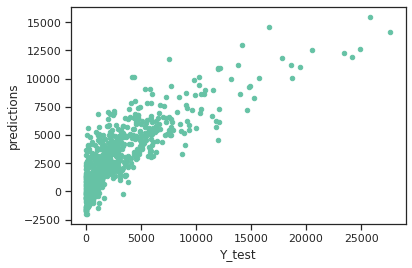

In [178]:
from sklearn import linear_model 

model_lr = linear_model.Lasso(alpha=0.01)
model_lr.fit(X_train_transformed, Y_train)

preds = model_lr.predict(X_test_transformed)
predictions_df = X_test_transformed.assign(predictions=preds)
predictions_df["Y_test"] = Y_test

predictions_df.plot(kind="scatter", x="Y_test", y="predictions")

In [179]:
# print the coefficients
print(model_lr.intercept_)
print(model_lr.coef_)

error = sqrt(mean_squared_error(Y_test,preds)) #calculate rmse
explained_variance = explained_variance_score(Y_test, preds)
r2 = r2_score(Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

-2568.981724411968
[ 6.19466522e-04 -4.02526960e-02 -2.09668322e-03  9.55351985e-02
 -2.73124833e-03  6.03028392e-02  4.90005346e-03 -9.58590104e-02
  8.66871837e-02  4.20079897e-04 -4.88170076e-03 -1.07181100e-02
  4.64775501e-03 -5.57023379e-04  1.45520776e-03 -1.06164330e+02
  7.10713617e-01  5.01557918e-04 -3.99816250e-02 -1.68331803e-03
  1.02367914e-01 -2.83253402e-03  6.26011937e-02  5.07631262e-03
 -1.02373063e-01  1.64138027e-01  5.56504926e-04 -6.44985441e-03
 -1.44592261e-02  2.49580259e-02 -7.16112328e-04  2.58346756e-03
 -8.79273334e-02  3.56576364e-02 -5.56997500e-02  1.93118123e-01
 -2.24718938e-01 -1.68738132e-02  1.45919802e-01  1.60258614e-02
 -4.99794521e-02  1.00421644e-01 -7.81417346e-02  3.89333258e-02
  4.49731490e-02 -3.16190558e-02  6.33090137e-03 -1.32423386e-01
  1.49624915e-01 -9.27569795e-03 -1.05686494e-02  1.06321114e-01
  2.66925072e-01]
MSE:  2107.288495288311
Explained variance:  0.6678341954684819
R^2:  0.667274719841421


In [180]:
from sklearn import linear_model 

alphas = [0.01, 0.1, 1]
print ('-------------------Lasso Regression: alpha 0.01-------------------')
model_lr_alpha_001 = linear_model.Lasso(alpha=0.01)
model_lr_alpha_001.fit(X_train_transformed, Y_train)

preds = model_lr_alpha_001.predict(X_test_transformed)
predictions_df = X_test_transformed.assign(predictions=preds)
predictions_df["Y_test"] = Y_test

#predictions_df.plot(kind="scatter", x="Y_test", y="predictions")

error = sqrt(mean_squared_error(Y_test,preds)) #calculate rmse
explained_variance = explained_variance_score(Y_test, preds)
r2 = r2_score(Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

print ('-------------------Lasso Regression: alpha 0.1-------------------')

model_lr_alpha01 = linear_model.Lasso(alpha=0.1)
model_lr_alpha01.fit(X_train_transformed, Y_train)

preds = model_lr_alpha01.predict(X_test_transformed)
predictions_df = X_test_transformed.assign(predictions=preds)
predictions_df["Y_test"] = Y_test

#predictions_df.plot(kind="scatter", x="Y_test", y="predictions")

error = sqrt(mean_squared_error(Y_test,preds)) #calculate rmse
explained_variance = explained_variance_score(Y_test, preds)
r2 = r2_score(Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

print ('-------------------Lasso Regression: alpha 1.0-------------------')

model_lr_alpha1 = linear_model.Lasso(alpha=1.0)
model_lr_alpha1.fit(X_train_transformed, Y_train)

preds = model_lr_alpha1.predict(X_test_transformed)
predictions_df = X_test_transformed.assign(predictions=preds)
predictions_df["Y_test"] = Y_test

#predictions_df.plot(kind="scatter", x="Y_test", y="predictions")

error = sqrt(mean_squared_error(Y_test,preds)) #calculate rmse
explained_variance = explained_variance_score(Y_test, preds)
r2 = r2_score(Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

-------------------Lasso Regression: alpha 0.01-------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6688696768.986252, tolerance: 3838388.0071303085
  positive)


MSE:  2107.288495288311
Explained variance:  0.6678341954684819
R^2:  0.667274719841421
-------------------Lasso Regression: alpha 0.1-------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6688728004.862824, tolerance: 3838388.0071303085
  positive)


MSE:  2107.2823195247033
Explained variance:  0.6678360861185144
R^2:  0.6672766700534305
-------------------Lasso Regression: alpha 1.0-------------------
MSE:  2107.220737216172
Explained variance:  0.6678549371148489
R^2:  0.6672961164951121


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6689039165.1611595, tolerance: 3838388.0071303085
  positive)


##### Ridge

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


MAE: -1406.008
Config: {'alpha': 0.99}
--------------------final model----------------------------
MSE:  2100.568701162121
Explained variance:  0.6704853528276706
R^2:  0.6693933481335193


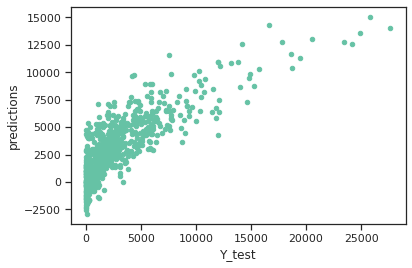

In [181]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedKFold
from sklearn.linear_model import Ridge
from numpy import arange

# define model
model = Ridge()

# define model evaluation method
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

# define grid
grid = dict()
grid['alpha'] = arange(0, 1, 0.01)

# define search
search = GridSearchCV(model, grid, scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)

# perform the search
results = search.fit(X_train_transformed, Y_train)

# summarize
print('MAE: %.3f' % results.best_score_)
print('Config: %s' % results.best_params_)

print('--------------------final model----------------------------')

# define model
model = Ridge(alpha=0.99)
# fit model
model.fit(X_train_transformed, Y_train)

# make a prediction
preds = model.predict(X_test_transformed)

predictions_df = X_test_transformed.assign(predictions=preds)
predictions_df["Y_test"] = Y_test

predictions_df.plot(kind="scatter", x="Y_test", y="predictions")

error = sqrt(mean_squared_error(Y_test,preds)) #calculate rmse
explained_variance = explained_variance_score(Y_test, preds)
r2 = r2_score(Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

##### ElasticNet

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6695125728.996982, tolerance: 3838388.0071303085
  positive)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5823646770.727735, tolerance: 3320392.558785399
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You

MSE:  2104.9954291401405
Explained variance:  0.6685334671798306
R^2:  0.6679984422615621
----------------with ElasticNetCV------------------


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5744969150.127042, tolerance: 3358112.7991982857
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5737409779.392332, tolerance: 3358112.7991982857
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5938896373.35648, tolerance: 3432162.896944958
  tol, rng, random, positive)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:472: ConvergenceWarning: Objective did not converge. You might want to incre

alpha value ---------> 0.0001
l1 ratio ------------> 0.5
-2568.976899858297
R2:0.667, MSE:4440666.15, RMSE:2107.29, EVS:0.67


/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 6688694212.78317, tolerance: 3838388.0071303085
  positive)


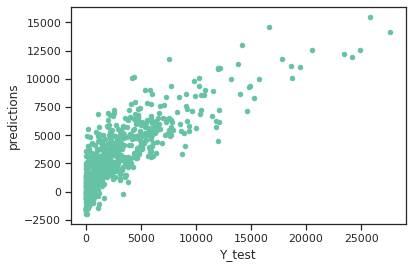

In [182]:
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import ElasticNet,ElasticNetCV

# define model
model = ElasticNet(alpha=1.0, l1_ratio=0.5)

# fit model
model.fit(X_train_transformed, Y_train)

# make a prediction
preds = model.predict(X_test_transformed)

predictions_df = X_test_transformed.assign(predictions=preds)
predictions_df["Y_test"] = Y_test

predictions_df.plot(kind="scatter", x="Y_test", y="predictions")

error = sqrt(mean_squared_error(Y_test,preds)) #calculate rmse
explained_variance = explained_variance_score(Y_test, preds)
r2 = r2_score(Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)


print('----------------with ElasticNetCV------------------')

alphas = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 1]

elastic_cv=ElasticNetCV(alphas=alphas, cv=10)
model = elastic_cv.fit(X_train_transformed, Y_train)
print("alpha value ---------> " + str(model.alpha_))
print("l1 ratio ------------> " + str(model.l1_ratio_))
print(model.intercept_)

ypred = model.predict(X_test_transformed)
score = model.score(X_test_transformed, Y_test)
mse = mean_squared_error(Y_test, ypred)
explained_variance = explained_variance_score(Y_test, ypred)
print("R2:{0:.3f}, MSE:{1:.2f}, RMSE:{2:.2f}, EVS:{3:.2f}"
      .format(score, mse, np.sqrt(mse), explained_variance))

##### RandomForestRegressor


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


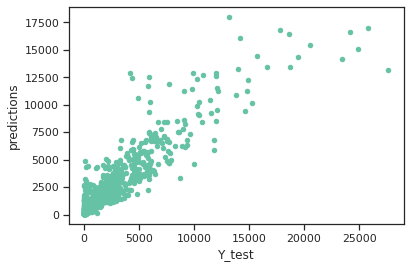

In [183]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor() 
regressor.fit(X_train_transformed, Y_train)

preds = regressor.predict(X_test_transformed)
predictions_df = X_test_transformed.assign(predictions=preds)
predictions_df["Y_test"] = Y_test

predictions_df.plot(kind="scatter", x="Y_test", y="predictions")

In [184]:
# print the coefficients
# print(regressor.intercept_)
# print(regressor.coef_)

print('----------------Random Forest Regressor------------------')

error = sqrt(mean_squared_error(Y_test,preds)) #calculate rmse
explained_variance = explained_variance_score(Y_test, preds)
r2 = r2_score(Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

----------------Random Forest Regressor------------------
MSE:  1566.151543601043
Explained variance:  0.8162173363470977
R^2:  0.816216984612346


#### Improve Model

The result of Random Forest Regressor seems better than all the other linear regression. Will try to optimizing the random forest model.
However, evaluating each model only on the training set can lead to one of the most fundamental problems in machine learning: overfitting. Therefore, the standard procedure for hyperparameter optimization accounts for overfitting through cross validation. we'll do this on the next part.

##### Random Search Cross Validation

Since we only have a vague idea of the best hyperparameters and thus the best approach to narrow our search is to evaluate a wide range of values for each hyperparameter.

In [185]:
#Please do not run this cell, might take up 166min

"""
from sklearn.model_selection import RandomizedSearchCV
from pprint import pprint
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 2, stop = 1000, num = 15)]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}

# Create the random grid
pprint(random_grid)


# Use the random grid to search for best hyperparameters
regressor = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 170 different combinations, and use all available cores
regressor_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, n_iter = 170, cv = 3 , verbose=2, random_state=42, n_jobs = -1)
regressor_random.fit(X_train_transformed, Y_train) 

regressor_random.best_params_

best_regressor_random = regressor_random.best_estimator_
# We can view the best parameters from fitting the random search:

print(regressor_random.get_params())


print('----------------Random Search CV------------------')

preds = best_regressor_random.predict(X_test_transformed)
error = sqrt(mean_squared_error(Y_test,preds)) 
explained_variance = explained_variance_score(Y_test, preds)
r2 = r2_score(Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

"""

'\nfrom sklearn.model_selection import RandomizedSearchCV\nfrom pprint import pprint\n# Number of trees in random forest\nn_estimators = [int(x) for x in np.linspace(start = 2, stop = 1000, num = 15)]\n# Maximum number of levels in tree\nmax_depth = [int(x) for x in np.linspace(10, 110, num = 11)]\n\nrandom_grid = {\'n_estimators\': n_estimators,\n               \'max_depth\': max_depth}\n\n# Create the random grid\npprint(random_grid)\n\n\n# Use the random grid to search for best hyperparameters\nregressor = RandomForestRegressor(random_state = 42)\n# Random search of parameters, using 3 fold cross validation, \n# search across 170 different combinations, and use all available cores\nregressor_random = RandomizedSearchCV(estimator = regressor, param_distributions = random_grid, n_iter = 170, cv = 3 , verbose=2, random_state=42, n_jobs = -1)\nregressor_random.fit(X_train_transformed, Y_train) \n\nregressor_random.best_params_\n\nbest_regressor_random = regressor_random.best_estimator_\

```
{'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110],
 'n_estimators': [2,
                  73,
                  144,
                  215,
                  287,
                  358,
                  429,
                  501,
                  572,
                  643,
                  714,
                  786,
                  857,
                  928,
                  1000]}
Fitting 3 folds for each of 165 candidates, totalling 495 fits
/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 165 is smaller than n_iter=170. Running 165 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  8.0min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 46.4min
[Parallel(n_jobs=-1)]: Done 361 tasks      | elapsed: 119.4min
[Parallel(n_jobs=-1)]: Done 495 out of 495 | elapsed: 166.3min finished
{'max_depth': 30, 'n_estimators': 73}
```


Output from previous:

```
{'cv': 3, 'error_score': nan, 'estimator__bootstrap': True, 'estimator__ccp_alpha': 0.0, 'estimator__criterion': 'mse', 'estimator__max_depth': None, 'estimator__max_features': 'auto', 'estimator__max_leaf_nodes': None, 'estimator__max_samples': None, 'estimator__min_impurity_decrease': 0.0, 'estimator__min_impurity_split': None, 'estimator__min_samples_leaf': 1, 'estimator__min_samples_split': 2, 'estimator__min_weight_fraction_leaf': 0.0, 'estimator__n_estimators': 100, 'estimator__n_jobs': None, 'estimator__oob_score': False, 'estimator__random_state': 42, 'estimator__verbose': 0, 'estimator__warm_start': False, 'estimator': RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False), 'iid': 'deprecated', 'n_iter': 170, 'n_jobs': -1, 'param_distributions': {'n_estimators': [2, 73, 144, 215, 287, 358, 429, 501, 572, 643, 714, 786, 857, 928, 1000], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]}, 'pre_dispatch': '2*n_jobs', 'random_state': 42, 'refit': True, 'return_train_score': False, 'scoring': None, 'verbose': 2}
MSE:  1498.2076349368513
Explained variance:  0.8217040009471824
R^2:  0.8215219611338961
```

To determine if random search yielded a better model, we compare the base model with the best random search model.

We achieved an unspectacular improvement on Training R-squared from 0.8137 --> 0.8215. 
Depending on the application though, this could be a significant benefit. We can further improve our results by using grid search to focus on the most promising hyperparameters ranges found in the random search.

##### Grid Search Cross Validation

Random search allowed us to narrow down the range for each hyperparameter. Now that we know where to concentrate our search, we can explicitly specify every combination of settings to try. We do this with GridSearchCV, a method that, instead of sampling randomly from a distribution, evaluates all combinations we define. To use Grid Search, we make another grid based on the best values provided by random search:

In [186]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 

param_grid = {
    'max_depth': [35, 37, 39, 41, 43, 45],
    'n_estimators': [70, 72, 74, 76]
}

# Create a based model
regressor = RandomForestRegressor()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = regressor, param_grid = param_grid, 
                          cv = 3, n_jobs = -1, verbose = 2)

grid_search.fit(X_train_transformed, Y_train)
grid_search.best_params_

best_regressor_gridsearch = grid_search.best_estimator_


print('----------------Grid Search CV------------------')

preds = best_regressor_gridsearch.predict(X_test_transformed)
error = sqrt(mean_squared_error(Y_test,preds)) 
explained_variance = explained_variance_score(Y_test, preds)
r2 = r2_score(Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done  72 out of  72 | elapsed:  3.7min finished


----------------Grid Search CV------------------
MSE:  1606.6067492540942
Explained variance:  0.8066215748731729
R^2:  0.8065997721993192


##### Conclusion

It seems we have about maxed out performance in Random Search, a small decrease in performance of Grid Search indicates we have reached diminishing returns for hyperparameter tuning. We've already found the best parameters in random search and grid search shows that!

### International: Try a simple linear regression

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_coordinate_descent.py:476: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 335778858.943048, tolerance: 126015.81566821111
  positive)
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


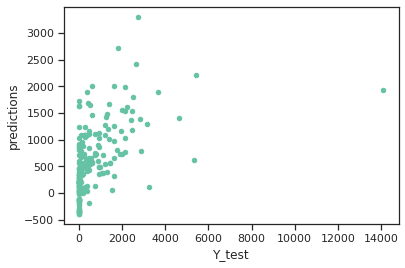

In [187]:
from sklearn import linear_model 

intl_model_lr = linear_model.Lasso(alpha=0.01)
intl_model_lr.fit(intl_X_train_transformed, intl_Y_train)

preds = intl_model_lr.predict(intl_X_test_transformed)
predictions_df = intl_X_test_transformed.assign(predictions=preds)
predictions_df["Y_test"] = intl_Y_test

predictions_df.plot(kind="scatter", x="Y_test", y="predictions")

In [188]:
# print the coefficients
print(intl_model_lr.intercept_)
print(intl_model_lr.coef_)

error = sqrt(mean_squared_error(intl_Y_test,preds)) #calculate rmse
explained_variance = explained_variance_score(intl_Y_test, preds)
r2 = r2_score(intl_Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

-2104.8458175349183
[ 1.13981935e-04 -1.63724622e-03 -4.19563070e-05  3.27060007e-05
 -7.91556092e-05  9.27083014e-04 -9.75638962e-05  2.47908142e-03
  6.35912253e-01  2.38035703e-05 -4.33547246e-04 -2.88568271e-04
  5.58887092e-03 -1.12980302e-05  1.43527095e-04 -1.99767449e+00
  2.59608516e+00  1.32282531e-04 -2.16414735e-04 -1.41108759e-04
  4.65499608e-04 -1.36121219e-04  3.47923273e-04 -1.09997081e-04
  6.80358021e-04  7.60451215e-01  2.49381129e-06 -3.14200643e-04
  1.62333947e-03  3.33727880e-03  5.33487986e-06  9.95611060e-05
 -1.36719655e-02  1.76058335e-03  2.52576352e-03  4.49350264e-02
 -4.11835277e-02 -3.55298564e-02  4.20534058e-02 -1.58261760e-02
  2.98774328e-02 -6.03205549e-02  3.63566174e-02 -1.73150430e-02
 -1.35734423e-02  6.85165969e-02 -1.31287174e-02 -6.60132465e-03
  4.54491486e-02 -1.73181206e-02 -2.97918705e-03 -3.00712251e-03
  3.42256544e-01]
MSE:  1193.260074960162
Explained variance:  0.2526612112776311
R^2:  0.24744545695499265


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


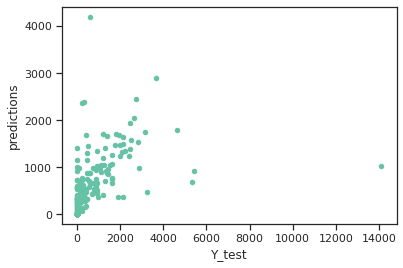

In [189]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor() 
regressor.fit(intl_X_train_transformed, intl_Y_train)

preds = regressor.predict(intl_X_test_transformed)
predictions_df = intl_X_test_transformed.assign(predictions=preds)
predictions_df["Y_test"] = intl_Y_test

predictions_df.plot(kind="scatter", x="Y_test", y="predictions")

In [190]:
# print the coefficients
# print(regressor.intercept_)
# print(regressor.coef_)

error = sqrt(mean_squared_error(intl_Y_test,preds)) #calculate rmse
explained_variance = explained_variance_score(intl_Y_test, preds)
r2 = r2_score(intl_Y_test, preds)
print("MSE: ", error)
print("Explained variance: ", explained_variance)
print("R^2: ", r2)

MSE:  1227.5883336603417
Explained variance:  0.20994778604854458
R^2:  0.2035229488523016
